# Overall pipeline
1. Website element detection
2. Credential classifier
3. Phishpedia logo identification
4. Layout matching model

<img src="../example.png" style="width:2000px;height:350px"/>

In [1]:
import os
os.chdir('..')
os.environ["CUDA_VISIBLE_DEVICES"]="0,1" # use all devices

In [2]:
from detectron2_1.datasets import WebMapper
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import funcy
from IPython.display import clear_output
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from pycocotools import cocoeval, coco
from detectron2.data import build_detection_test_loader, MetadataCatalog, DatasetCatalog
import numpy as np
import tldextract
import pickle
import torch
import torch.nn.functional as F
import time
from collections import OrderedDict

In [3]:
from credential_classifier.bit_pytorch.models import FCMaxPool
from credential_classifier.bit_pytorch.grid_divider import read_img_reverse

In [4]:
from phishpedia.models import KNOWN_MODELS
from phishpedia.utils import brand_converter
from phishpedia.inference import siamese_inference, pred_siamese, siamese_inference_debug
from phishpedia.utils import brand_converter

In [5]:
from layout_matcher.layout_matcher_knn import bipartite_web
from layout_matcher.misc import load_yaml
from layout_matcher.heuristic import layout_heuristic

In [6]:
from tqdm import tqdm

In [7]:
from layout import *
from siamese import *
from element_detector import *
from credential import *

## Main function

In [8]:
# element recognition model
ele_cfg, ele_model = element_config(rcnn_weights_path = 'output/website_lr0.001/model_final.pth', 
                                    rcnn_cfg_path='configs/faster_rcnn_web.yaml')


In [9]:
# # old logo recognition model
# logo_cfg, logo_model = element_config(rcnn_weights_path = '../detectron2_1/output/rcnn_2/rcnn_bet365.pth', 
#                                       rcnn_cfg_path='../detectron2_1/output/rcnn_2/config.yaml')

In [10]:
cls_model = credential_config(checkpoint='credential_classifier/FCMax_0.05.pth.tar')

In [11]:
pedia_model, logo_feat_list, file_name_list = phishpedia_config(num_classes=277, 
                                                weights_path='phishpedia/resnetv2_rgb_new.pth.tar',
                                                targetlist_path='phishpedia/expand_targetlist/')

  1%|▏         | 4/277 [00:01<01:28,  3.10it/s]/home/l/liny/anaconda3/envs/mypy37_junyang/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 277/277 [01:20<00:00,  3.44it/s]


In [12]:
file_name_list.shape

(3048,)

- Element detector

In [15]:
# phish30k_dir = '../phishpedia/benchmark/test30k/phish_sample_30k'
# domain_map_path = 'phishpedia/domain_map.pkl'
# write_txt = 'results/phishpedia_phish30k_0.83.txt'

# with open(write_txt, 'w') as f:
#     f.write('folder\t')
#     f.write('true_brand\t')   
#     f.write('phish_category\t')
#     f.write('pred_brand\t')   
#     f.write('runtime_element_recognition\t')   
#     f.write('runtime_siamese\n')  

In [16]:
# for folder in tqdm(os.listdir(phish30k_dir)):
        
    phish_category = 0 # 0 for benign, 1 for phish, by default is benign
    pred_target = None # predicted target, default is None
    
    img_path = os.path.join(phish30k_dir, folder, 'shot.png')
    url = eval(open(os.path.join(phish30k_dir, folder, 'info.txt'), encoding = "ISO-8859-1").read())
    url = url['url'] if isinstance(url, dict) else url
    
    # Element recognition module
    start_time = time.time()
    pred_classes, pred_boxes, pred_scores = element_recognition(img=img_path, model=ele_model)
    ele_recog_time = time.time() - start_time
    
    # If no element is reported
    if len(pred_boxes) == 0:
        phish_category = 0 # Report as benign
        
    # If at least one element is reported
    else: 
        # Phishpedia module
        start_time = time.time()
        pred_target = phishpedia_classifier(pred_classes=pred_classes, pred_boxes=pred_boxes, 
                                            domain_map_path=domain_map_path,
                                            model=pedia_model, 
                                            logo_feat_list=logo_feat_list, file_name_list=file_name_list, 
                                            url=url,
                                            shot_path=img_path,
                                            ts=0.83)
        siamese_time = time.time() - start_time

        # Phishpedia reports target
        if pred_target is not None:
            phish_category = 1 # Report as phish

        # Phishpedia does not report target
        else: # Report as benign
            phish_category = 0
            
    # write to txt file
    with open(write_txt, 'a+') as f:
        f.write(folder+'\t')
        f.write(brand_converter(folder.split('+')[0])+'\t') # true brand
        f.write(str(phish_category)+'\t') # phish/benign
        f.write(brand_converter(pred_target)+'\t') if pred_target is not None else f.write('\t')# phishing target
        # element recognition time
        f.write(str(ele_recog_time)+'\t') 
        #siamese time
        f.write(str(siamese_time)+'\n') if 'siamese_time' in locals() else f.write('\n') 
    
    # delete time variables
    try:
        del ele_recog_time
        del siamese_time
    except:
        pass

100%|██████████| 29496/29496 [1:35:53<00:00,  5.13it/s]  


- Element detector + Credential classifier

In [85]:
# phish30k_dir = '../phishpedia/benchmark/test30k/phish_sample_30k'
# domain_map_path = 'phishpedia/domain_map.pkl'
# write_txt = 'results/phishpedia_phish30k_0.83_v2_conf.txt'

# with open(write_txt, 'w') as f:
#     f.write('folder\t')
#     f.write('true_brand\t')   
#     f.write('phish_category\t')
#     f.write('pred_brand\t')   
#     f.write('runtime_element_recognition\t')   
#     f.write('runtime_credential_classifier\t')
#     f.write('runtime_siamese\n')  

In [ ]:
# for folder in tqdm(os.listdir(phish30k_dir)):
        
    phish_category = 0 # 0 for benign, 1 for phish, by default is benign
    pred_target = None # predicted target, default is None
    
    img_path = os.path.join(phish30k_dir, folder, 'shot.png')
    url = eval(open(os.path.join(phish30k_dir, folder, 'info.txt'), encoding = "ISO-8859-1").read())
    url = url['url'] if isinstance(url, dict) else url
    
    # Element recognition module
    start_time = time.time()
    pred_classes, pred_boxes, pred_scores = element_recognition(img=img_path, model=ele_model)
    ele_recog_time = time.time() - start_time
    
    # If no element is reported
    if len(pred_boxes) == 0:
        phish_category = 0 # Report as benign
        
    # If at least one element is reported
    else: 
        # Credential classifier module
        start_time = time.time()
        cre_pred, cre_conf = credential_classifier(img=img_path, coords=pred_boxes, types=pred_classes, model=cls_model)
        credential_cls_time = time.time() - start_time
        
        # Credential page: conservative classification
        if cre_conf >= 0.35: 

            # Phishpedia module
            start_time = time.time()
            pred_target = phishpedia_classifier(pred_classes=pred_classes, pred_boxes=pred_boxes, 
                                                domain_map_path=domain_map_path,
                                                model=pedia_model, 
                                                logo_feat_list=logo_feat_list, file_name_list=file_name_list, 
                                                url=url,
                                                shot_path=img_path,
                                                ts=0.83)
            siamese_time = time.time() - start_time

            # Phishpedia reports target
            if pred_target is not None:
                phish_category = 1 # Report as phish

            # Phishpedia does not report target
            else: # Report as benign
                phish_category = 0
                
        # Non-credential page: conservative classification
        elif cre_conf < 0.35: 
            # TODO: dynamic module here
            phish_category = 0 # Report as benign

            
    # write to txt file
    with open(write_txt, 'a+') as f:
        f.write(folder+'\t')
        f.write(brand_converter(folder.split('+')[0])+'\t') # true brand
        f.write(str(phish_category)+'\t') # phish/benign
        f.write(brand_converter(pred_target)+'\t') if pred_target is not None else f.write('\t')# phishing target
        # element recognition time
        f.write(str(ele_recog_time)+'\t') 
        # credential classifier time
        f.write(str(credential_cls_time)+'\t') if 'credential_cls_time' in locals() else f.write('\t')
        #siamese time
        f.write(str(siamese_time)+'\n') if 'siamese_time' in locals() else f.write('\n') 
    
    # delete time variables
    try:
        del ele_recog_time
        del credential_cls_time
        del siamese_time
    except:
        pass

  6%|▌         | 1664/29496 [06:13<1:27:15,  5.32it/s] 

- Element detector + Credential classifier + Layout matcher

In [281]:
# phish30k_dir = '../phishpedia/benchmark/test30k/phish_sample_30k'
# domain_map_path = 'phishpedia/domain_map.pkl'
# layout_cfg_dir = 'layout_matcher/configs.yaml'
# layout_ref_dir = 'layout_matcher/layout_reference'
# layout_ts = 0.4 # TODO: set this ts
# write_txt = 'results/phishintention_phish30k_0.83_ts0.4_v2.txt'

# with open(write_txt, 'w') as f:
#     f.write('folder\t')
#     f.write('true_brand\t')   
#     f.write('phish_category\t')
#     f.write('pred_brand\t')   
#     f.write('runtime_element_recognition\t')   
#     f.write('runtime_credential_classifier\t')   
#     f.write('runtime_siamese\t')  
#     f.write('runtime_layout\n')

In [282]:
    
# for folder in tqdm(os.listdir(phish30k_dir)):
    
#     phish_category = 0 # 0 for benign, 1 for suspicious, 2 for phish
#     pred_target = None # predicted target, default is None
    
#     img_path = os.path.join(phish30k_dir, folder, 'shot.png')
#     url = eval(open(os.path.join(phish30k_dir, folder, 'info.txt'), encoding = "ISO-8859-1").read())
#     url = url['url'] if isinstance(url, dict) else url
    
#     # Element recognition module
#     start_time = time.time()
#     pred_classes, pred_boxes, pred_scores = element_recognition(img=img_path, model=ele_model)
#     ele_recog_time = time.time() - start_time
    
#     # If no element is reported
#     if len(pred_boxes) == 0:
#         phish_category = 0 # Report as benign
        
#     # If at least one element is reported
#     else:
#         # Credential classifier module
#         start_time = time.time()
#         cre_pred, _ = credential_classifier(img=img_path, coords=pred_boxes, types=pred_classes, model=cls_model)
#         credential_cls_time = time.time() - start_time
        
#         # Credential page
#         if cre_pred == 0: 
#             # Phishpedia module
#             start_time = time.time()
#             pred_target = phishpedia_classifier(pred_classes=pred_classes, pred_boxes=pred_boxes, 
#                                                 domain_map_path=domain_map_path,
#                                                 model=pedia_model, 
#                                                 logo_feat_list=logo_feat_list, file_name_list=file_name_list,
#                                                 url=url,
#                                                 shot_path=img_path,
#                                                 ts=0.83)
#             siamese_time = time.time() - start_time

#             # Phishpedia reports target 
#             if pred_target is not None:
#                 # Layout module is only built w.r.t specific brands (social media brands)
#                 if pred_target not in ['Amazon', 'Facebook', 'Google', 'Instagram', 
#                                        'LinkedIn Corporation', 'ms_skype', 'Twitter, Inc.']:
#                     phish_category = 2 # Report as phish
                
#                 else: 
#                     # Layout template matching
#                     layout_cfg, gt_coords_arr, gt_files_arr, gt_shot_size_arr = layout_config(cfg_dir=layout_cfg_dir, 
#                                                                                        ref_dir=layout_ref_dir, 
#                                                                                        matched_brand=pred_target)
#                     start_time = time.time()
#                     max_s, max_site = layout_matcher(pred_boxes=pred_boxes, img=img_path, 
#                                    gt_coords_arr=gt_coords_arr, gt_files_arr=gt_files_arr, gt_shot_size_arr=gt_shot_size_arr,
#                                    cfg=layout_cfg)
#                     layout_time = time.time() - start_time

#                     # Success layout match
#                     if max_s >= layout_ts: 
#                         phish_category = 2 # Report as phish

#                     # Un-successful layout match
#                     else: 
#                         phish_category = 1 # Report as suspicious

#             # Phishpedia does not report target
#             else: # Report as benign
#                 phish_category = 0

#         # Non-credential page
#         elif cre_pred == 1: 
#             # TODO: dynamic module here
#             phish_category = 0 # Report as benign
            
#     # write to txt file
#     with open(write_txt, 'a+') as f:
#         f.write(folder+'\t')
#         f.write(brand_converter(folder.split('+')[0])+'\t') # true brand
#         f.write(str(phish_category)+'\t') # phish/benign/suspicious
#         f.write(brand_converter(pred_target)+'\t') if pred_target is not None else f.write('\t')# phishing target
#         # element recognition time
#         f.write(str(ele_recog_time)+'\t') 
#         # credential classifier time
#         f.write(str(credential_cls_time)+'\t') if 'credential_cls_time' in locals() else f.write('\t') 
#         # siamese time
#         f.write(str(siamese_time)+'\t') if 'siamese_time' in locals() else f.write('\t') 
#         # layout time
#         f.write(str(layout_time)+'\n') if 'layout_time' in locals() else f.write('\n') 
        
#     # delete time variables
#     try:
#         del ele_recog_time
#         del credential_cls_time
#         del siamese_time
#         del layout_time
#     except:
#         pass
            

  0%|          | 26/29496 [00:08<5:11:55,  1.57it/s]/home/l/liny/anaconda3/envs/mypy37_junyang/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 29496/29496 [3:13:06<00:00,  2.55it/s]   


- Element detector + Credential heuristic + Credential classifier + Siamese

In [14]:
phish30k_dir = '../phishpedia/benchmark/test30k/phish_sample_30k'
domain_map_path = 'phishpedia/domain_map.pkl'
layout_cfg_dir = 'layout_matcher/configs.yaml'
write_txt = 'results/phishintention_phish30k_0.83_heu_new.txt'

with open(write_txt, 'w') as f:
    f.write('folder\t')
    f.write('true_brand\t')   
    f.write('phish_category\t')
    f.write('pred_brand\t')   
    f.write('runtime_element_recognition\t')   
    f.write('runtime_credential_classifier\t')   
    f.write('runtime_siamese\n')  

In [15]:
    
for folder in tqdm(os.listdir(phish30k_dir)):
    
    phish_category = 0 # 0 for benign, 1 for phish
    pred_target = None # predicted target, default is None
    
    img_path = os.path.join(phish30k_dir, folder, 'shot.png')
    url = eval(open(os.path.join(phish30k_dir, folder, 'info.txt'), encoding = "ISO-8859-1").read())
    url = url['url'] if isinstance(url, dict) else url
    
    # Element recognition module
    start_time = time.time()
    pred_classes, pred_boxes, pred_scores = element_recognition(img=img_path, model=ele_model)
    ele_recog_time = time.time() - start_time
    
    # If no element is reported
    if len(pred_boxes) == 0:
        phish_category = 0 # Report as benign
        
    # If at least one element is reported
    else:
        # Credential heuristic module
        start_time = time.time()
        pattern_ct, len_input = layout_heuristic(pred_boxes, pred_classes)
        if len_input == 0:
            cre_pred = 1
        elif pattern_ct >= 2:
            cre_pred = 0
        else:
            # Credential classifier module
            cre_pred, _ = credential_classifier(img=img_path, coords=pred_boxes, 
                                                types=pred_classes, model=cls_model)
        credential_cls_time = time.time() - start_time
        
        # Credential page
        if cre_pred == 0: 
            # Phishpedia module
            start_time = time.time()
            pred_target = phishpedia_classifier(pred_classes=pred_classes, pred_boxes=pred_boxes, 
                                                domain_map_path=domain_map_path,
                                                model=pedia_model, 
                                                logo_feat_list=logo_feat_list, file_name_list=file_name_list,
                                                url=url,
                                                shot_path=img_path,
                                                ts=0.83)
            siamese_time = time.time() - start_time

            # Phishpedia reports target 
            if pred_target is not None:
                phish_category = 1 # Report as phishing

            # Phishpedia does not report target
            else: # Report as benign
                phish_category = 0

        # Non-credential page
        elif cre_pred == 1: 
            # TODO: dynamic module here
            phish_category = 0 # Report as benign
            
    # write to txt file
    with open(write_txt, 'a+') as f:
        f.write(folder+'\t')
        f.write(brand_converter(folder.split('+')[0])+'\t') # true brand
        f.write(str(phish_category)+'\t') # phish/benign/suspicious
        f.write(brand_converter(pred_target)+'\t') if pred_target is not None else f.write('\t')# phishing target
        # element recognition time
        f.write(str(ele_recog_time)+'\t') 
        # credential classifier/heuristic time
        f.write(str(credential_cls_time)+'\t') if 'credential_cls_time' in locals() else f.write('\t') 
        # siamese time
        f.write(str(siamese_time)+'\n') if 'siamese_time' in locals() else f.write('\n') 
        
    # delete time variables
    try:
        del ele_recog_time
        del credential_cls_time
        del siamese_time
    except:
        pass
            

100%|██████████| 29496/29496 [1:12:29<00:00,  6.78it/s]


- On phishdiscovery dataset

In [13]:
discovery_dir = '../phishpedia/benchmark/phish_discovery/All/fp'
domain_map_path = 'phishpedia/domain_map.pkl'
write_txt = 'results/phishintention_discovery_0.83_heu_new.txt'

with open(write_txt, 'w') as f:
    f.write('folder\t')
    f.write('true_brand\t')   
    f.write('phish_category\t')
    f.write('pred_brand\t')   
    f.write('runtime_element_recognition\t')   
    f.write('runtime_credential_classifier\t')   
    f.write('runtime_siamese\n')  

In [14]:
    
for folder in tqdm(os.listdir(discovery_dir)):
    
    phish_category = 0 # 0 for benign, 1 for phish
    pred_target = None # predicted target, default is None
    
    img_path = os.path.join(discovery_dir, folder, 'shot.png')
    url = open(os.path.join(discovery_dir, folder, 'info.txt'), encoding = "ISO-8859-1").read()
    
    # Element recognition module
    start_time = time.time()
    pred_classes, pred_boxes, pred_scores = element_recognition(img=img_path, model=ele_model)
    ele_recog_time = time.time() - start_time
    
    # If no element is reported
    if len(pred_boxes) == 0:
        phish_category = 0 # Report as benign
        
    # If at least one element is reported
    else:
        # Credential heuristic module
        start_time = time.time()
        pattern_ct, len_input = layout_heuristic(pred_boxes, pred_classes)
        if len_input == 0:
            cre_pred = 1
        elif pattern_ct >= 2:
            cre_pred = 0
        else:
            # Credential classifier module
            cre_pred, _ = credential_classifier(img=img_path, coords=pred_boxes, 
                                                types=pred_classes, model=cls_model)
        credential_cls_time = time.time() - start_time
        
        # Credential page
        if cre_pred == 0: 
            # Phishpedia module
            start_time = time.time()
            pred_target = phishpedia_classifier(pred_classes=pred_classes, pred_boxes=pred_boxes, 
                                                domain_map_path=domain_map_path,
                                                model=pedia_model, 
                                                logo_feat_list=logo_feat_list, file_name_list=file_name_list,
                                                url=url,
                                                shot_path=img_path,
                                                ts=0.83)
            siamese_time = time.time() - start_time

            # Phishpedia reports target 
            if pred_target is not None:
                phish_category = 1 # Report as phishing

            # Phishpedia does not report target
            else: # Report as benign
                phish_category = 0

        # Non-credential page
        elif cre_pred == 1: 
            # TODO: dynamic module here
            phish_category = 0 # Report as benign
            
    # write to txt file
    with open(write_txt, 'a+') as f:
        f.write(folder+'\t')
        f.write(brand_converter(folder.split('+')[0])+'\t') # true brand
        f.write(str(phish_category)+'\t') # phish/benign/suspicious
        f.write(brand_converter(pred_target)+'\t') if pred_target is not None else f.write('\t')# phishing target
        # element recognition time
        f.write(str(ele_recog_time)+'\t') 
        # credential classifier/heuristic time
        f.write(str(credential_cls_time)+'\t') if 'credential_cls_time' in locals() else f.write('\t') 
        # siamese time
        f.write(str(siamese_time)+'\n') if 'siamese_time' in locals() else f.write('\n') 
        
    # delete time variables
    try:
        del ele_recog_time
        del credential_cls_time
        del siamese_time
    except:
        pass
            

100%|██████████| 2258/2258 [05:19<00:00,  7.07it/s]


- Test single site

In [25]:
# img_path = 'datasets/train_imgs/Amazon.com Inc.+2020-08-16-15`54`25.png'
# domain_map_path = 'phishpedia/domain_map.pkl'

# pred_classes, pred_boxes, pred_scores = element_recognition(img=img_path, model=ele_model)

# cls_pred = credential_classifier(img_path, pred_boxes, pred_classes, cls_model)

# pred_target = phishpedia_classifier(pred_classes=pred_classes, pred_boxes=pred_boxes, 
#                                     domain_map_path=domain_map_path,
#                                     model=pedia_model, 
#                                     logo_feat_list=logo_feat_list, file_name_list=file_name_list, 
#                                     shot_path=img_path,
#                                     url='https://www.kkk.com',
#                                     ts=0.83)

# layout_cfg, gt_coords_arr, gt_files_arr, gt_shot_size_arr = layout_config(cfg_dir='layout_matcher/configs.yaml', 
#                                                                    ref_dir='layout_matcher/layout_reference', 
#                                                                    matched_brand=pred_target)

# max_s, max_site = layout_matcher(pred_boxes=pred_boxes, img=img_path, 
#                                  gt_coords_arr=gt_coords_arr, gt_files_arr=gt_files_arr, gt_shot_size_arr=gt_shot_size_arr,
#                                  cfg=layout_cfg)

In [33]:
# check = cv2.imread(img_path)
# for j, box in enumerate(pred_boxes):
#     cv2.rectangle(check, (box[0], box[1]), (box[2], box[3]), (36, 255, 12), 2)
#     cv2.putText(check, str(pred_classes[j].item()), (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

# plt.figure(figsize=(20,20))
# plt.imshow(check[:, :, ::-1])

## Evaluation

In [15]:
import pandas as pd

In [16]:
def phishpedia_classifier_debug(pred_classes, pred_boxes, 
                          domain_map_path,
                          model, logo_feat_list, file_name_list, shot_path, 
                          url, 
                          ts):
    
    # targetlist domain list
    with open(domain_map_path, 'rb') as handle:
        domain_map = pickle.load(handle)
        
    # look at boxes for logo class only
    logo_boxes = pred_boxes[pred_classes==0] 
    
    # run logo matcher
    pred_target = None
    if len(logo_boxes) > 0:
        # siamese prediction for logo box
        for i, coord in enumerate(logo_boxes):
            min_x, min_y, max_x, max_y = coord
            bbox = [float(min_x), float(min_y), float(max_x), float(max_y)]
            target_this, domain_this = siamese_inference_debug(model, domain_map, 
                                                         logo_feat_list, file_name_list,
                                                         shot_path, bbox, t_s=ts, grayscale=False)
            
            # domain matcher to avoid FP
            if not target_this is None and tldextract.extract(url).domain not in domain_this: 
                pred_target = target_this 
                break # break if target is matched
    
    return brand_converter(pred_target)

In [17]:
def evaluate(result_path, gt_type):
    assert gt_type in ['phish', 'benign'] # gt type is either phish/benign
    results = [x.strip() for x in open(result_path).readlines()]
    mat = [n.split('\t') for n in results]
    df = pd.DataFrame(mat)
    df.columns = df.iloc[0]
    df = df.reindex(df.index.drop(0))
    return df

- Phishpedia v1

In [27]:
result = evaluate(result_path='results/phishpedia_phish30k_0.83.txt', gt_type='phish')
correct = result.iloc[np.where(result['true_brand'] == result['pred_brand'])[0], :]
num_match = np.sum(result['true_brand'] == result['pred_brand'])
print(num_match)
fn_nopred = result.iloc[np.where((result['true_brand'] != result['pred_brand']) & (result['pred_brand'] == ''))[0], :]
fn_wrongpred = result.iloc[np.where(((result['true_brand']) != result['pred_brand']) & (result['pred_brand'] != ''))[0], :]

- Phishpedia v2

In [87]:
result_v2 = evaluate(result_path='results/phishpedia_phish30k_0.83_v2.txt', gt_type='phish')
fn_nopred_v2 = result_v2.iloc[np.where((result_v2['true_brand'] != result_v2['pred_brand']) & (result_v2['pred_brand'] == ''))[0], :]
print(np.sum(result_v2['true_brand'] == result_v2['pred_brand']))
# new fns created by credential classifier
new_fn = fn_nopred_v2.iloc[np.where(fn_nopred_v2['folder'].isin(list(correct['folder'])))[0], :]

In [ ]:
ct = 0
domain_map_path = 'phishpedia/domain_map.pkl'
for folder in list(new_fn['folder']):
        
    img_path = '../phishpedia/benchmark/test30k/phish_sample_30k/{}/shot.png'.format(folder)
    url = eval(open('../phishpedia/benchmark/test30k/phish_sample_30k/{}/info.txt'.format(folder), encoding = "ISO-8859-1").read())['url']

    pred_classes, pred_boxes, pred_scores = element_recognition(img=img_path,
                                                                model=ele_model)
    
    cre_pred, cre_conf = credential_classifier(img=img_path, coords=pred_boxes, types=pred_classes, model=cls_model)

    if cre_pred == 1:
        print('Wrongly predicted as non credential')
    
    else: # this should not be executed 
        pred_target = phishpedia_classifier_debug(pred_classes=pred_classes, pred_boxes=pred_boxes, 
                                        domain_map_path=domain_map_path,
                                        model=pedia_model, 
                                        logo_feat_list=logo_feat_list, file_name_list=file_name_list, 
                                        url=url,
                                        shot_path=img_path,
                                        ts=0.83)
    check = cv2.imread(img_path)
    for j, box in enumerate(pred_boxes):
        cv2.rectangle(check, (box[0], box[1]), (box[2], box[3]), (36, 255, 12), 2)
        cv2.putText(check, str(pred_classes[j].item()), (box[0], box[1]+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
    print(folder)
    plt.figure(figsize=(20,20))
    plt.title(str(round(cre_conf, 5)))
    plt.imshow(check[:, :, ::-1])
    plt.show()
    ct += 1
    if ct >= 50:
        break

- PhishIntention

In [18]:
df = evaluate(result_path='results/phishintention_discovery_0.83_heu_new.txt', gt_type='phish')

In [19]:
df.head(5)

0                       folder                   true_brand phish_category  \
1      jmiverizon.wpengine.com      jmiverizon.wpengine.com              0   
2          astmapodkontrola.pl          astmapodkontrola.pl              0   
3         intranet.leonnetz.de         intranet.leonnetz.de              0   
4  teilhabeberatung.livecdn.de  teilhabeberatung.livecdn.de              0   
5   www.carretasmontoro.com.br   www.carretasmontoro.com.br              0   

0 pred_brand runtime_element_recognition runtime_credential_classifier  \
1                    0.19649839401245117        0.00010132789611816406   
2                    0.12338376045227051        0.00010228157043457031   
3                    0.09799385070800781         8.940696716308594e-05   
4                    0.08591532707214355         8.463859558105469e-05   
5                    0.11674618721008301           0.03626108169555664   

0 runtime_siamese  
1            None  
2            None  
3            None  
4            None  
5            None

In [20]:
num_det = np.sum(df['pred_brand'] != '')
num_det

150

In [21]:
df_interest = df.iloc[np.where(df['pred_brand'] != '')[0], :]

In [22]:
from collections import Counter
Counter(df_interest['pred_brand']).most_common(10)

[('Google', 52),
 ('Facebook', 14),
 ('Microsoft', 13),
 ('Visa International Service Association', 11),
 ('Dropbox', 6),
 ('GoDaddy', 5),
 ('Instagram', 5),
 ('Desjardins', 4),
 ('Amazon', 4),
 ('Luno', 3)]

Credential category 0 with confidence None
www.rojgarfarm.online


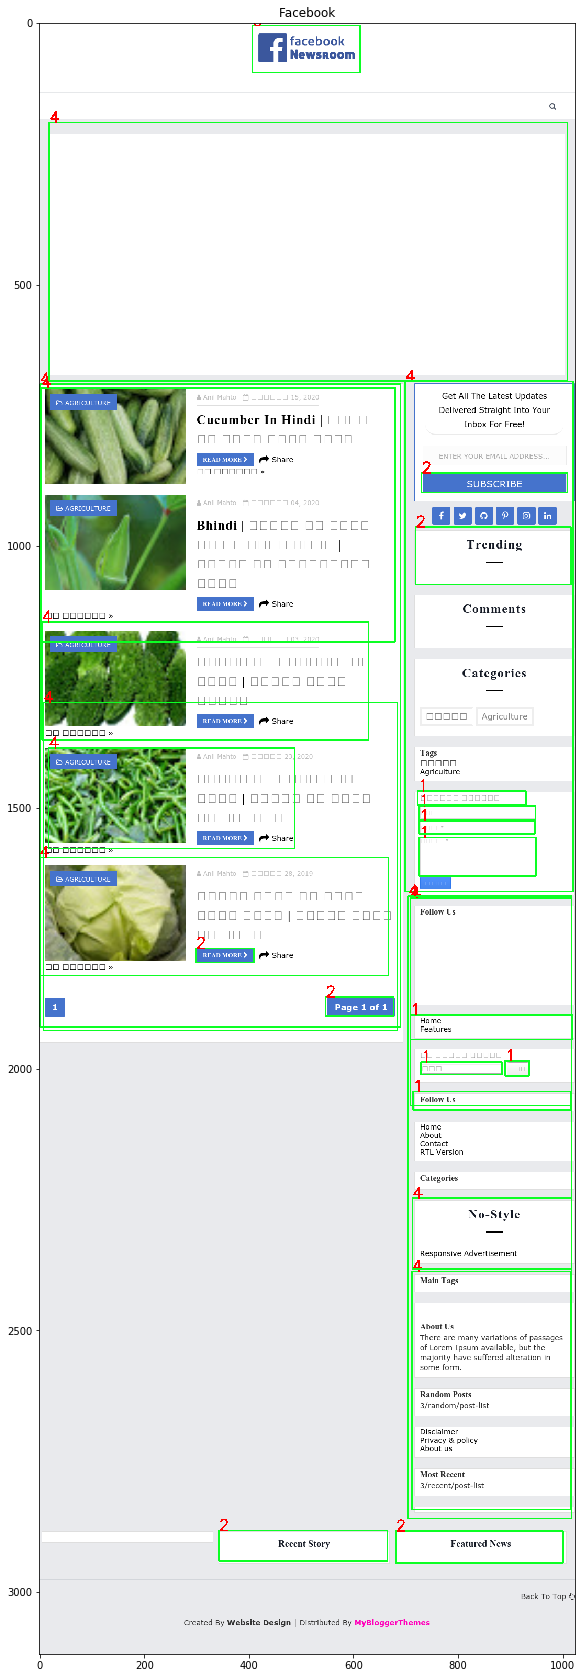

Credential category 0 with confidence None
doimatkhaufb2019.com


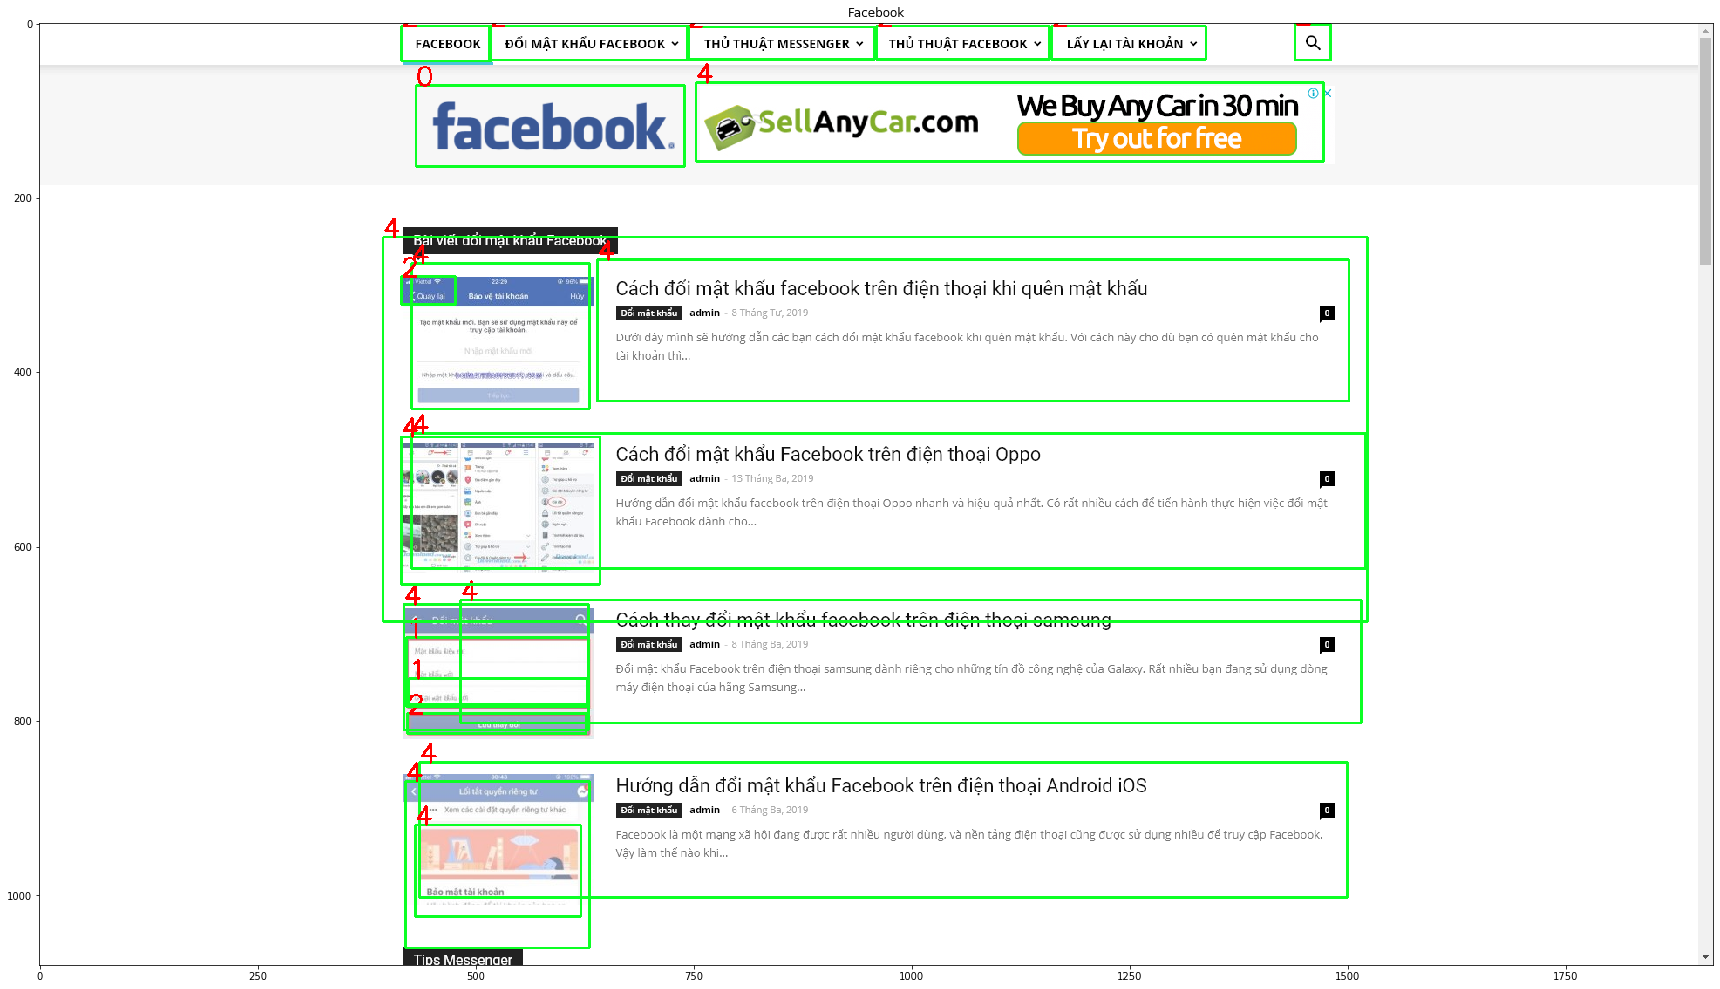

Credential category 0 with confidence 0.7559035420417786
wordpress-316180-982438.cloudwaysapps.com


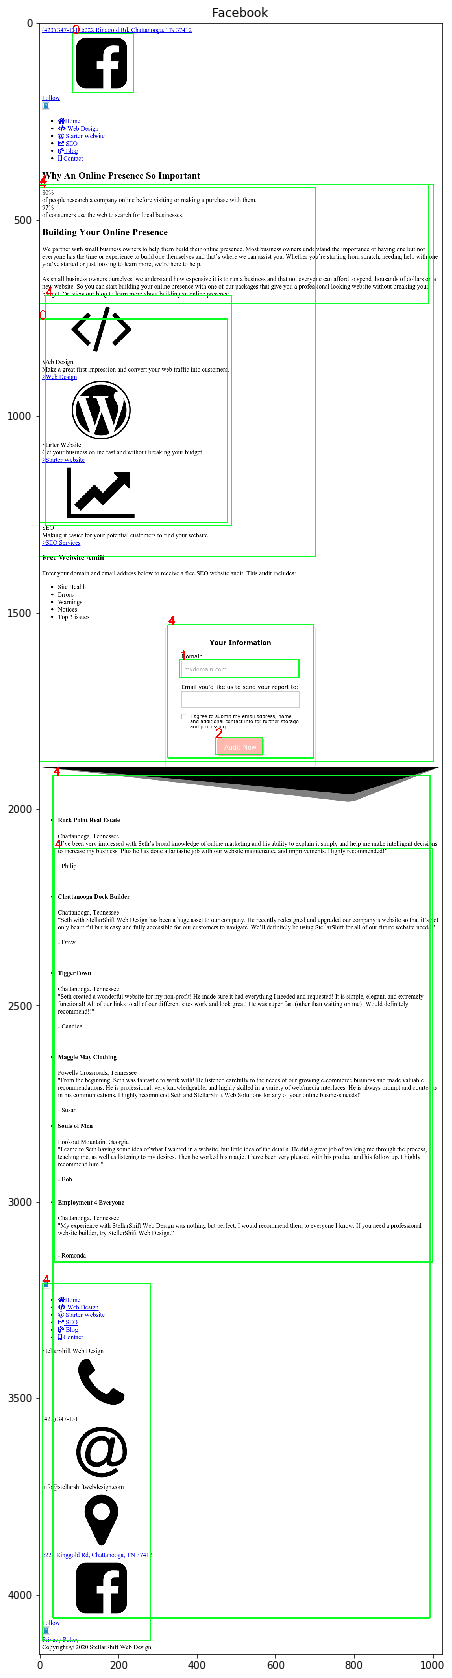

Credential category 0 with confidence None
www.officebeaver.co.uk


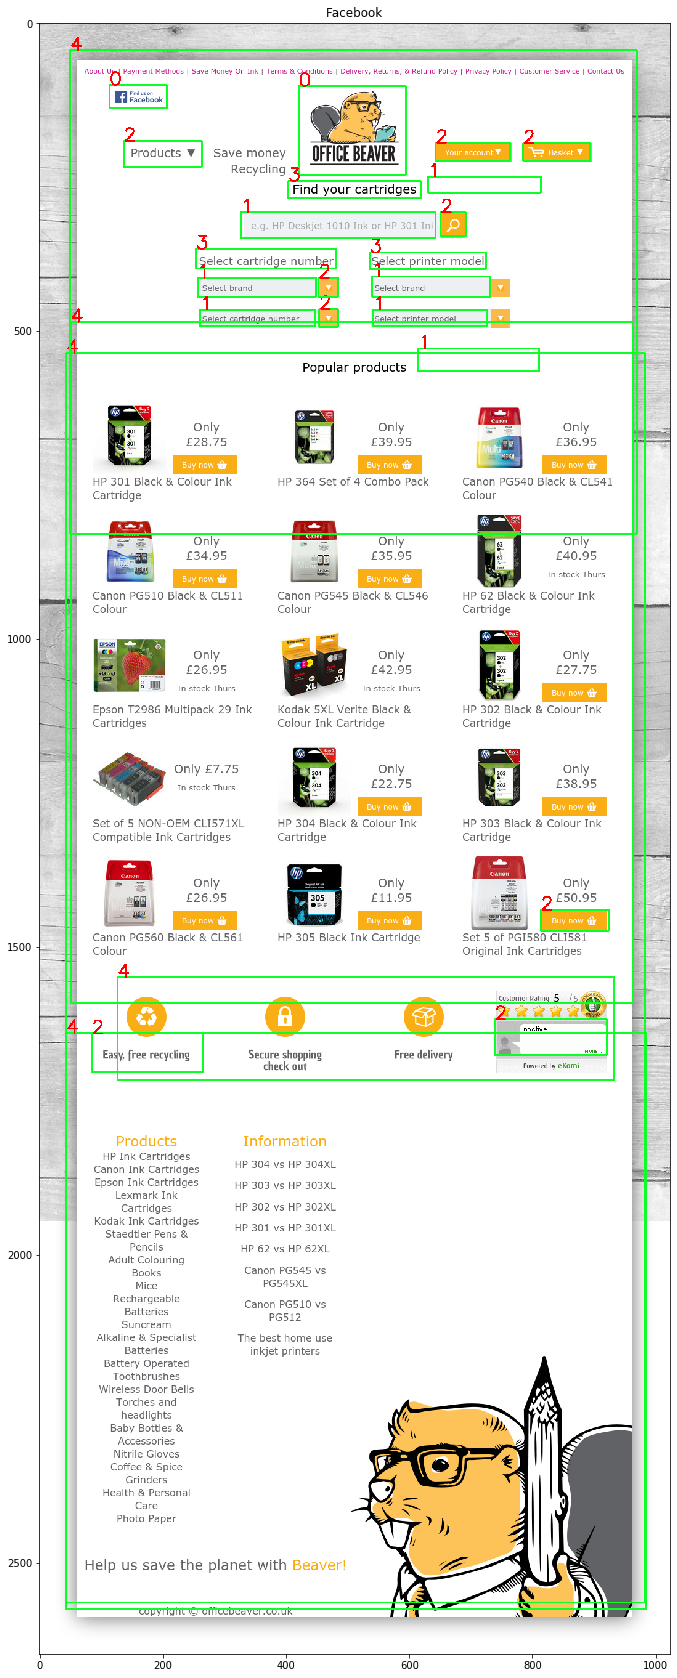

Credential category 0 with confidence None
icelandcarrent-net.formulaoffroad.net


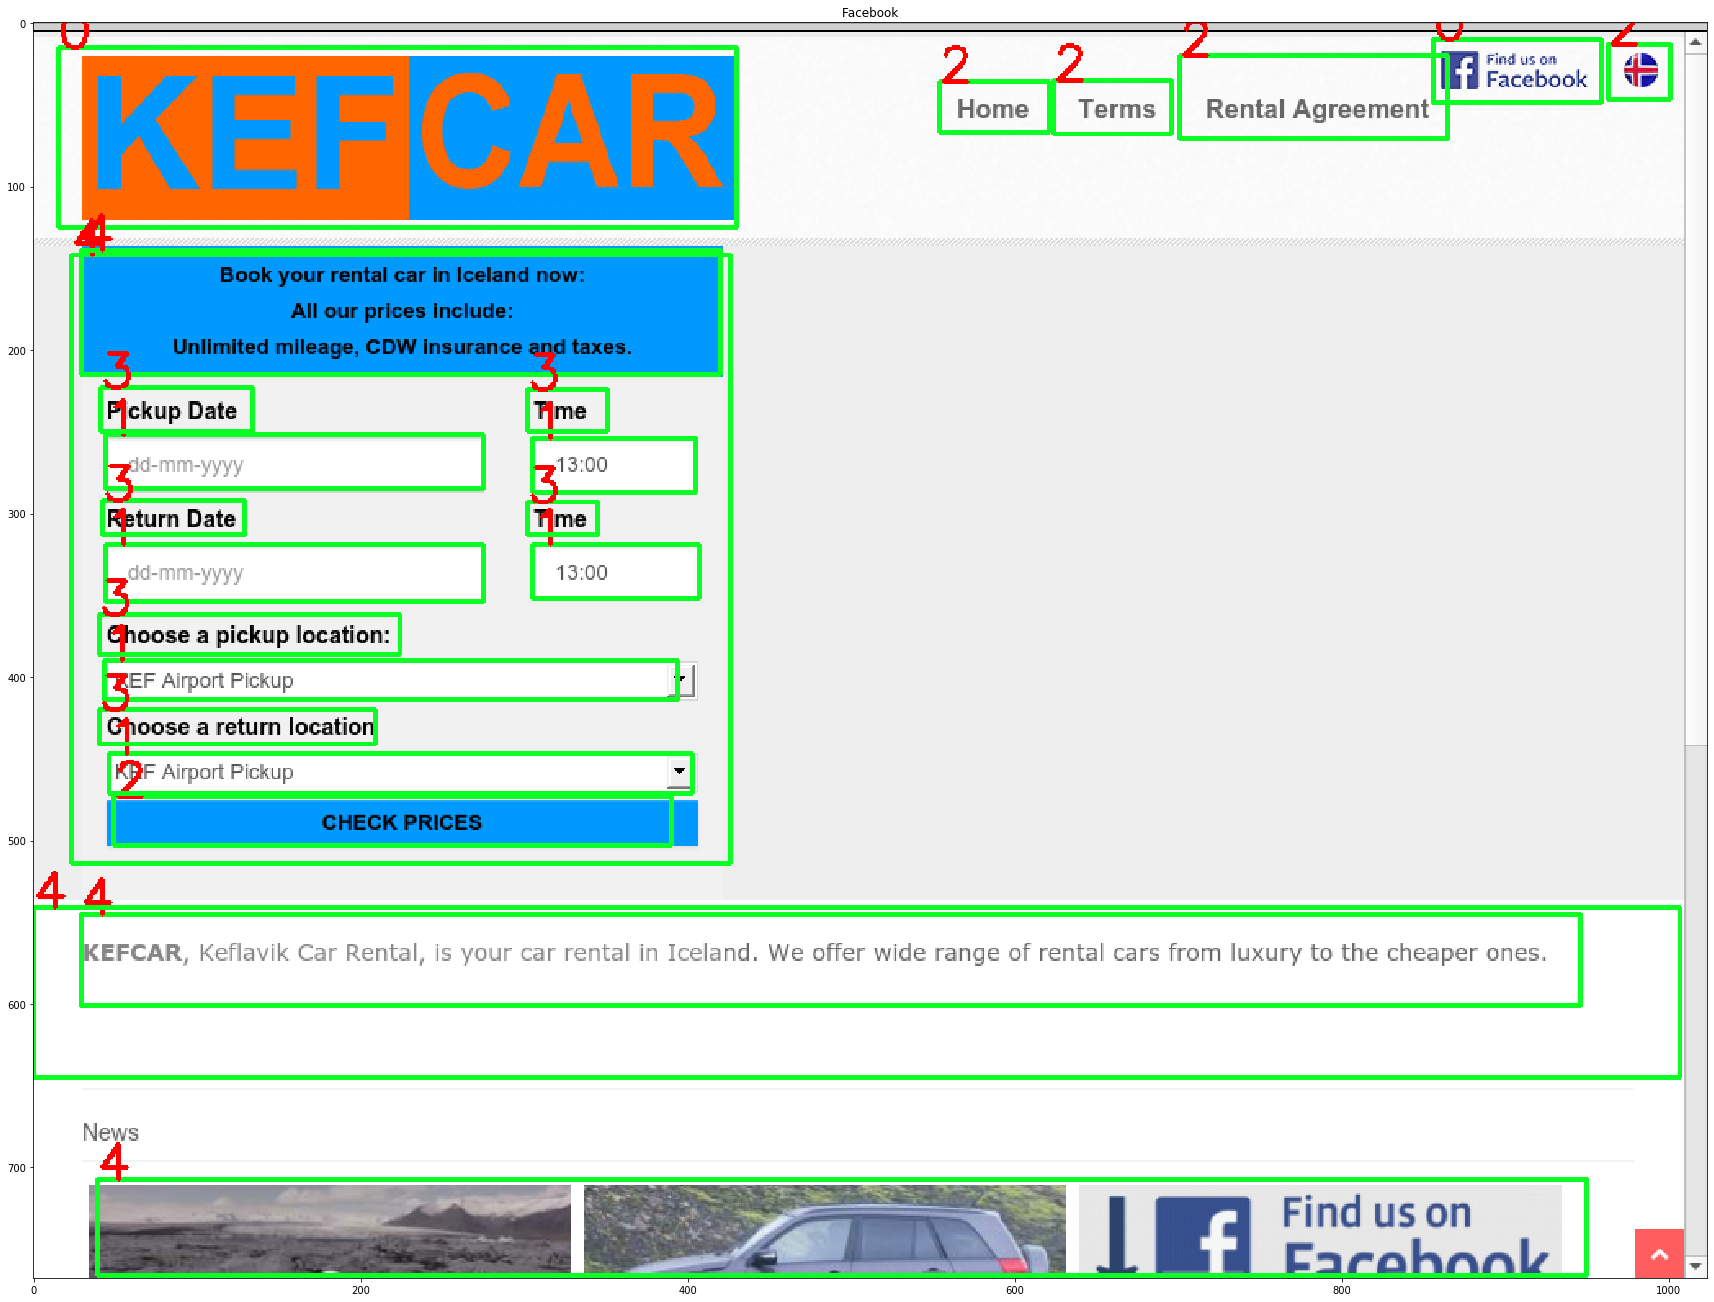

Credential category 0 with confidence None
www.clivecroft.com


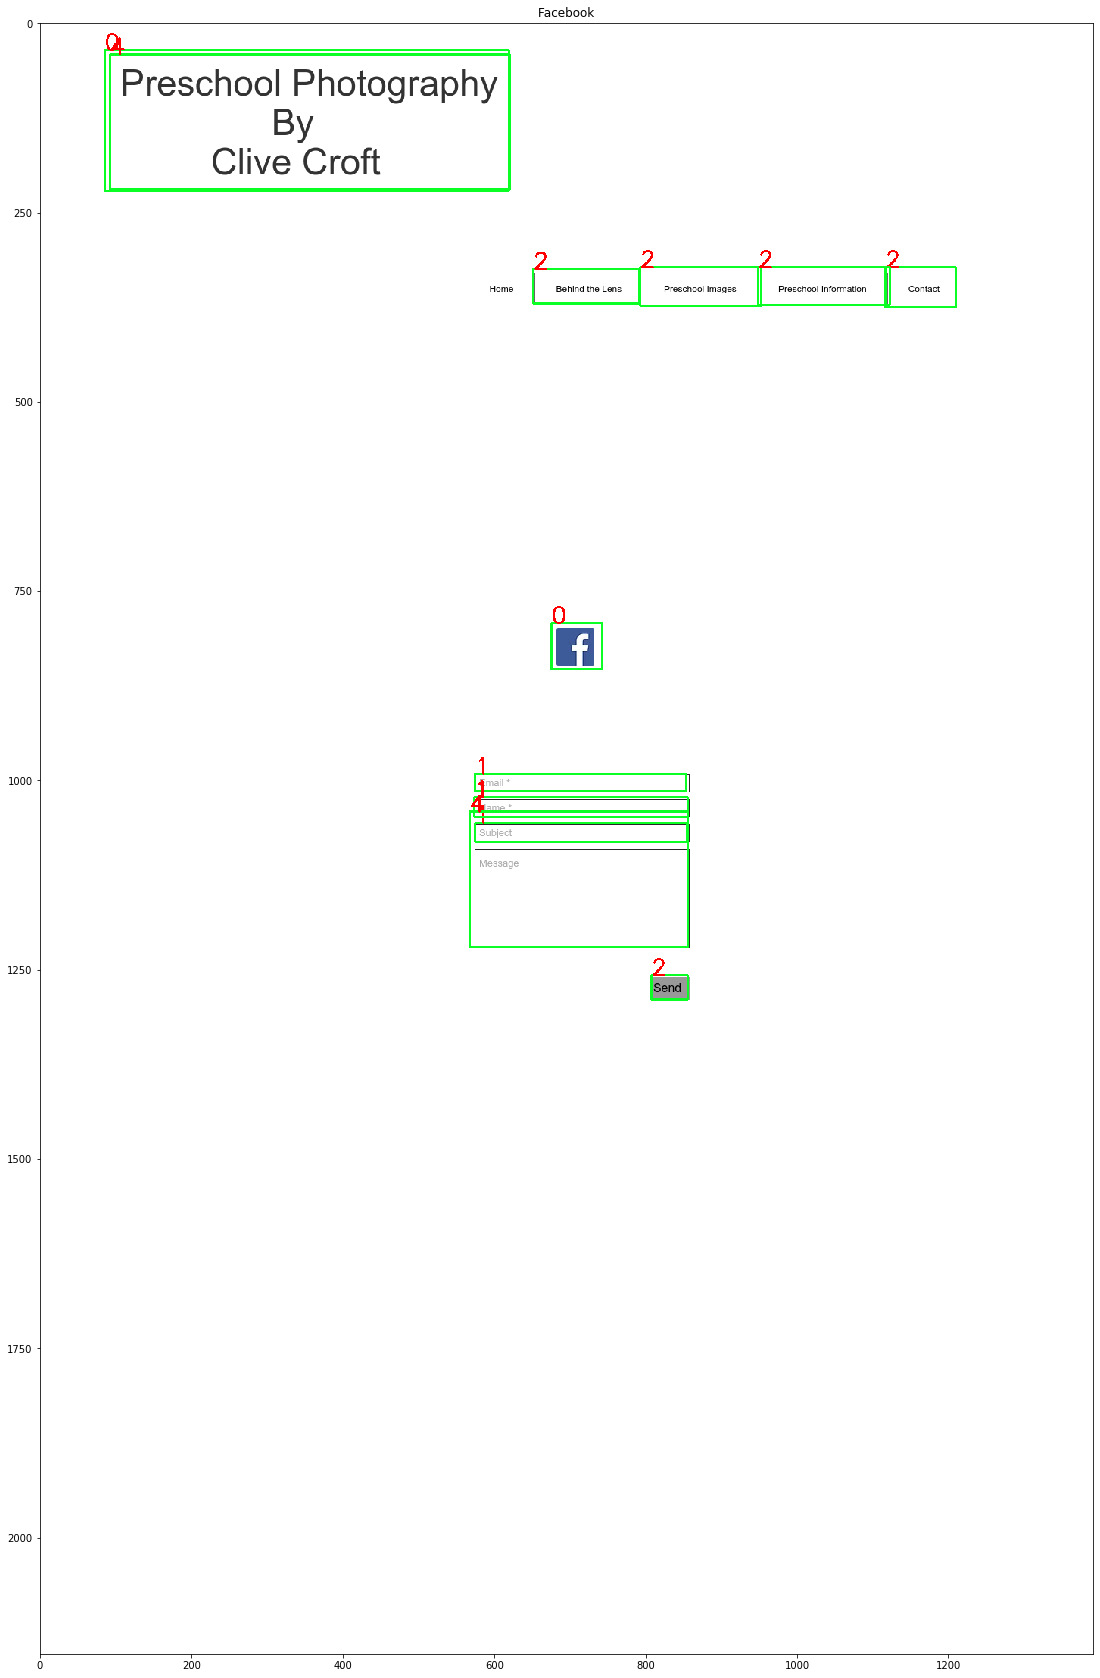

Credential category 0 with confidence 0.8368301391601562
facebook.outageaustralia.com.au


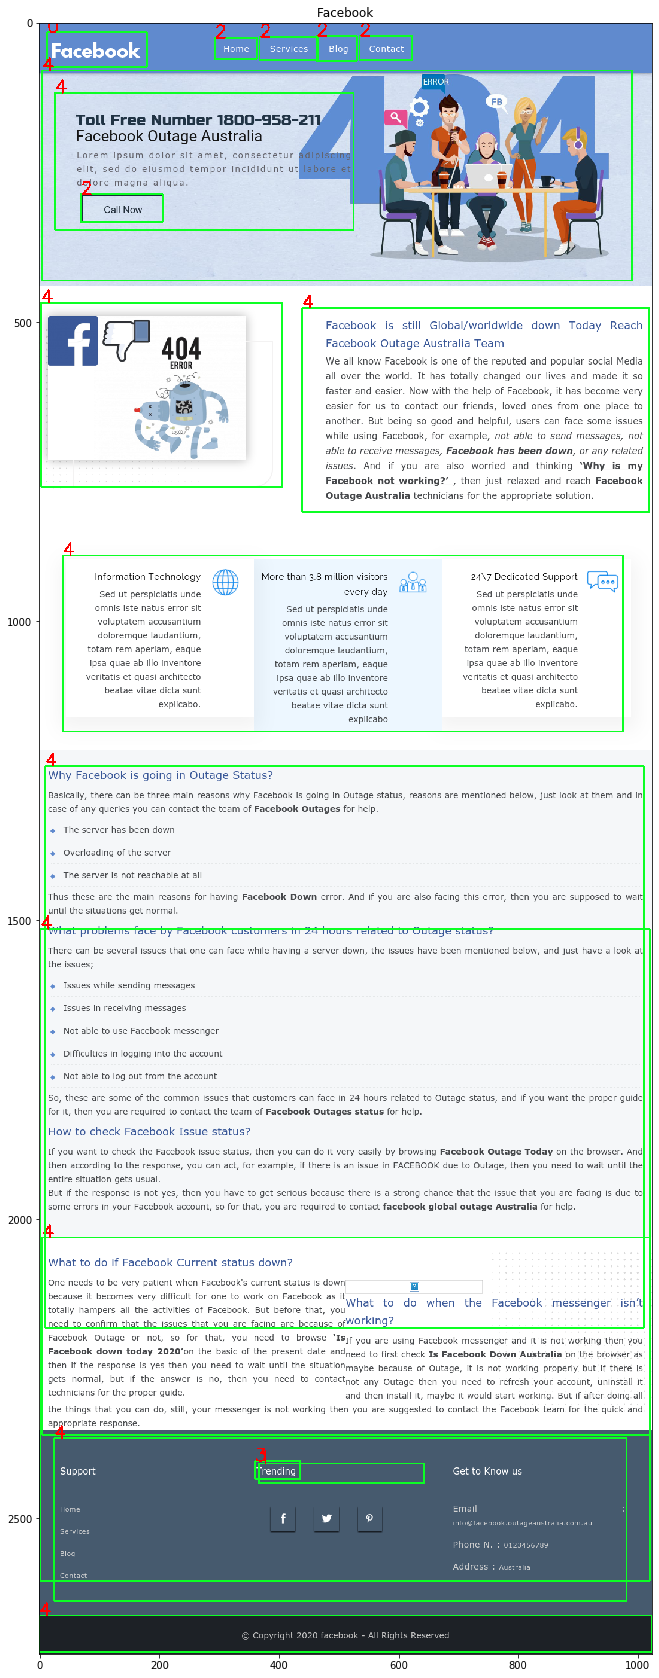

Credential category 0 with confidence None
hire-is.formulaoffroad.net


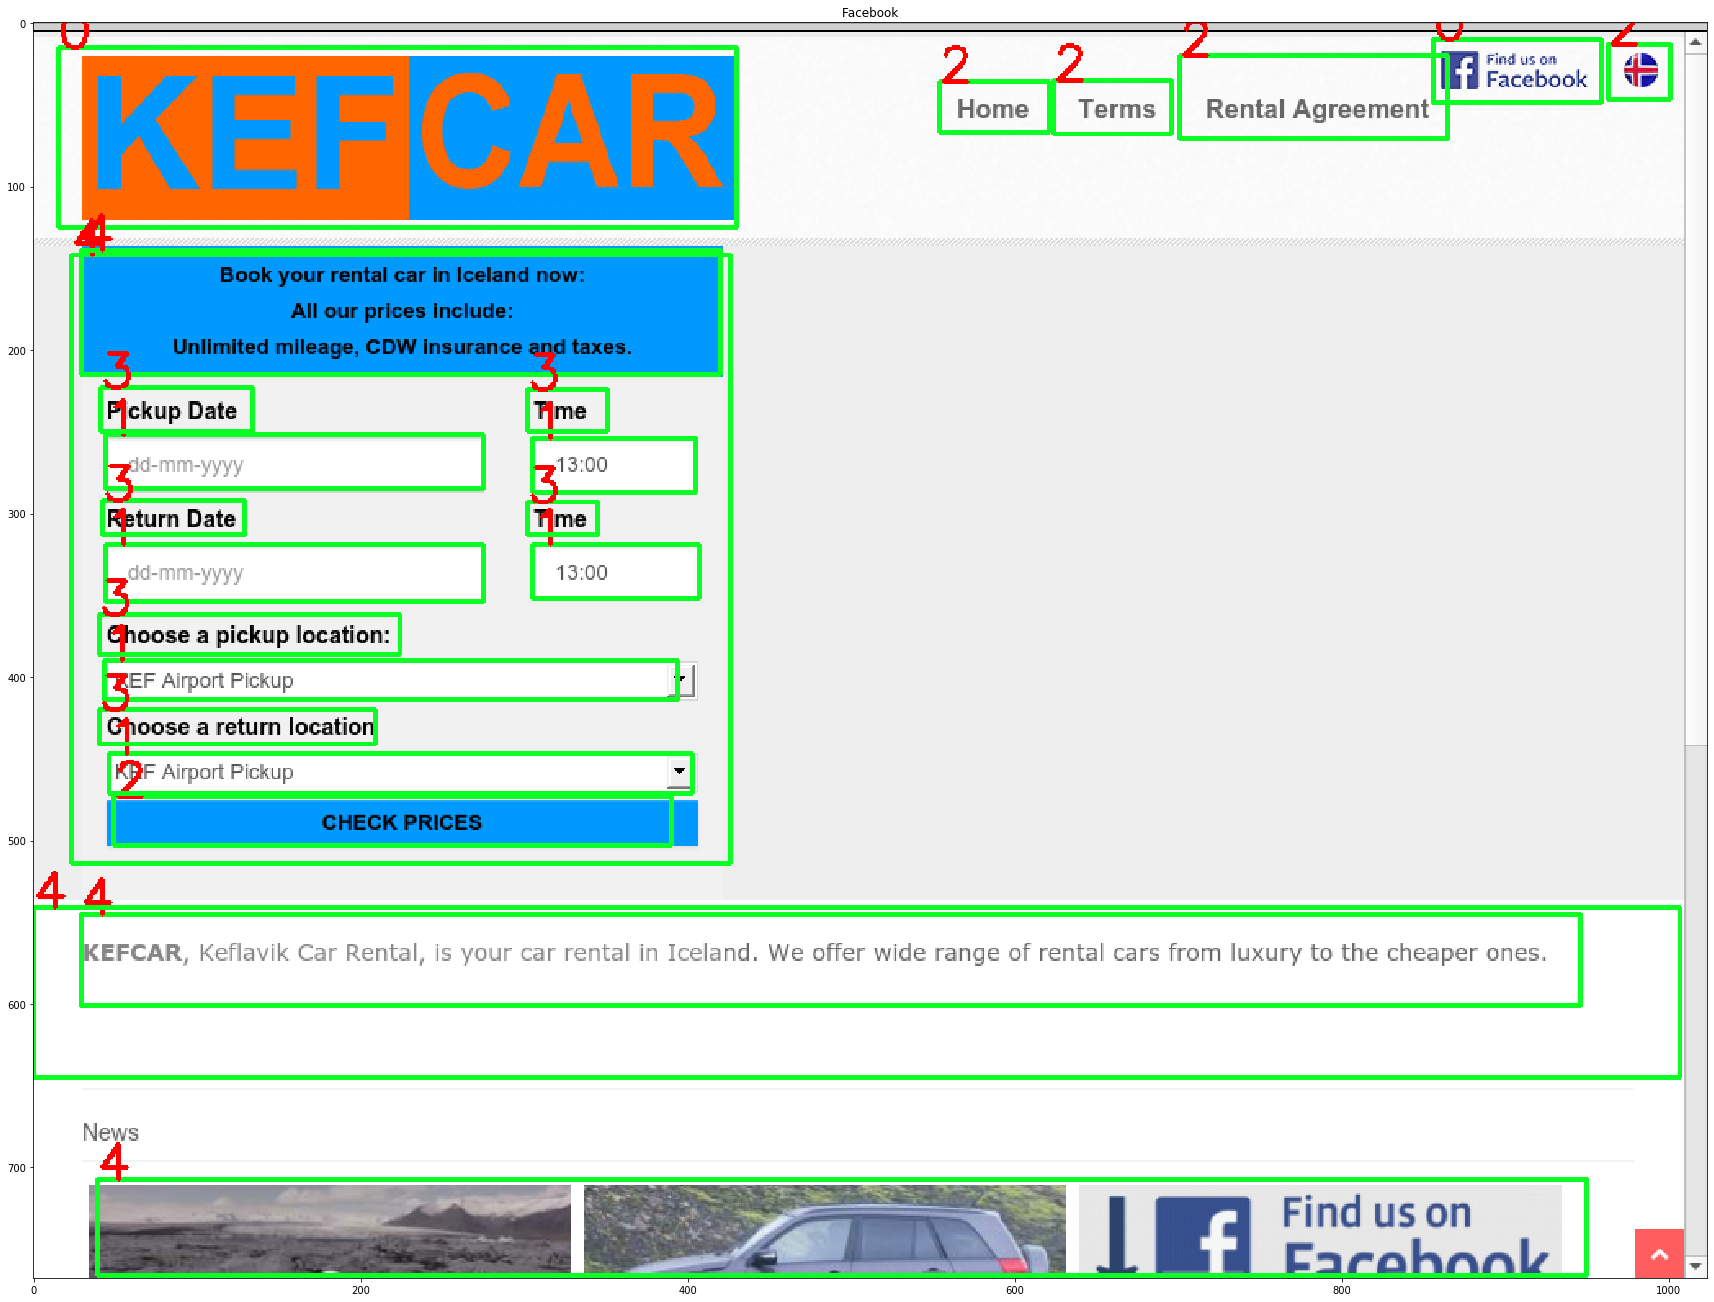

Credential category 0 with confidence None
al-magor.co.il


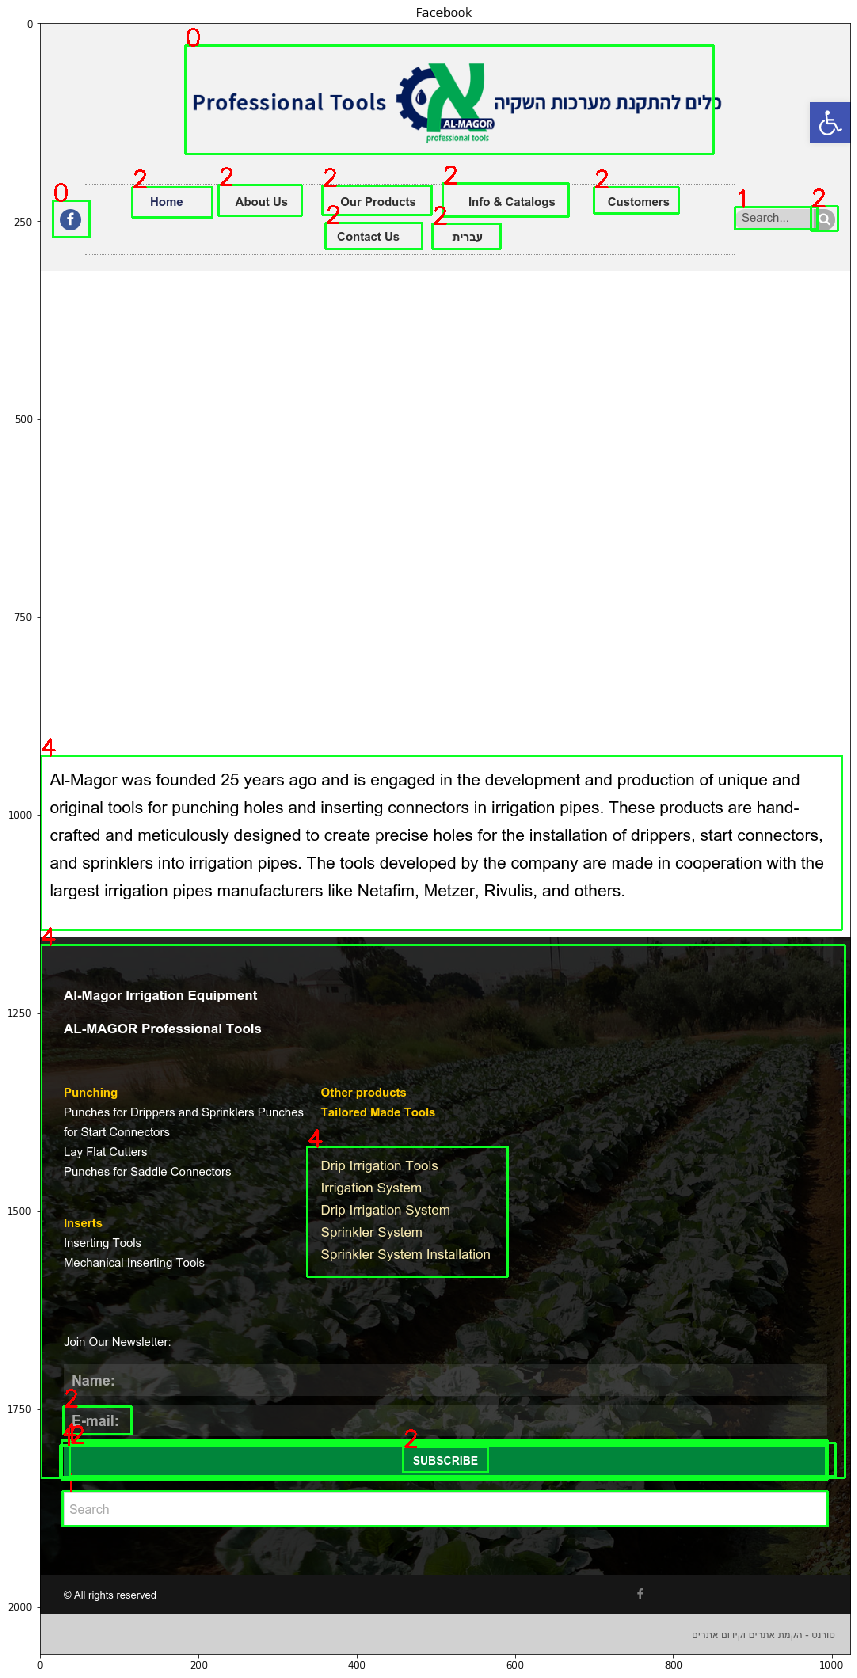

Credential category 0 with confidence None
thecao.blogbatam.info


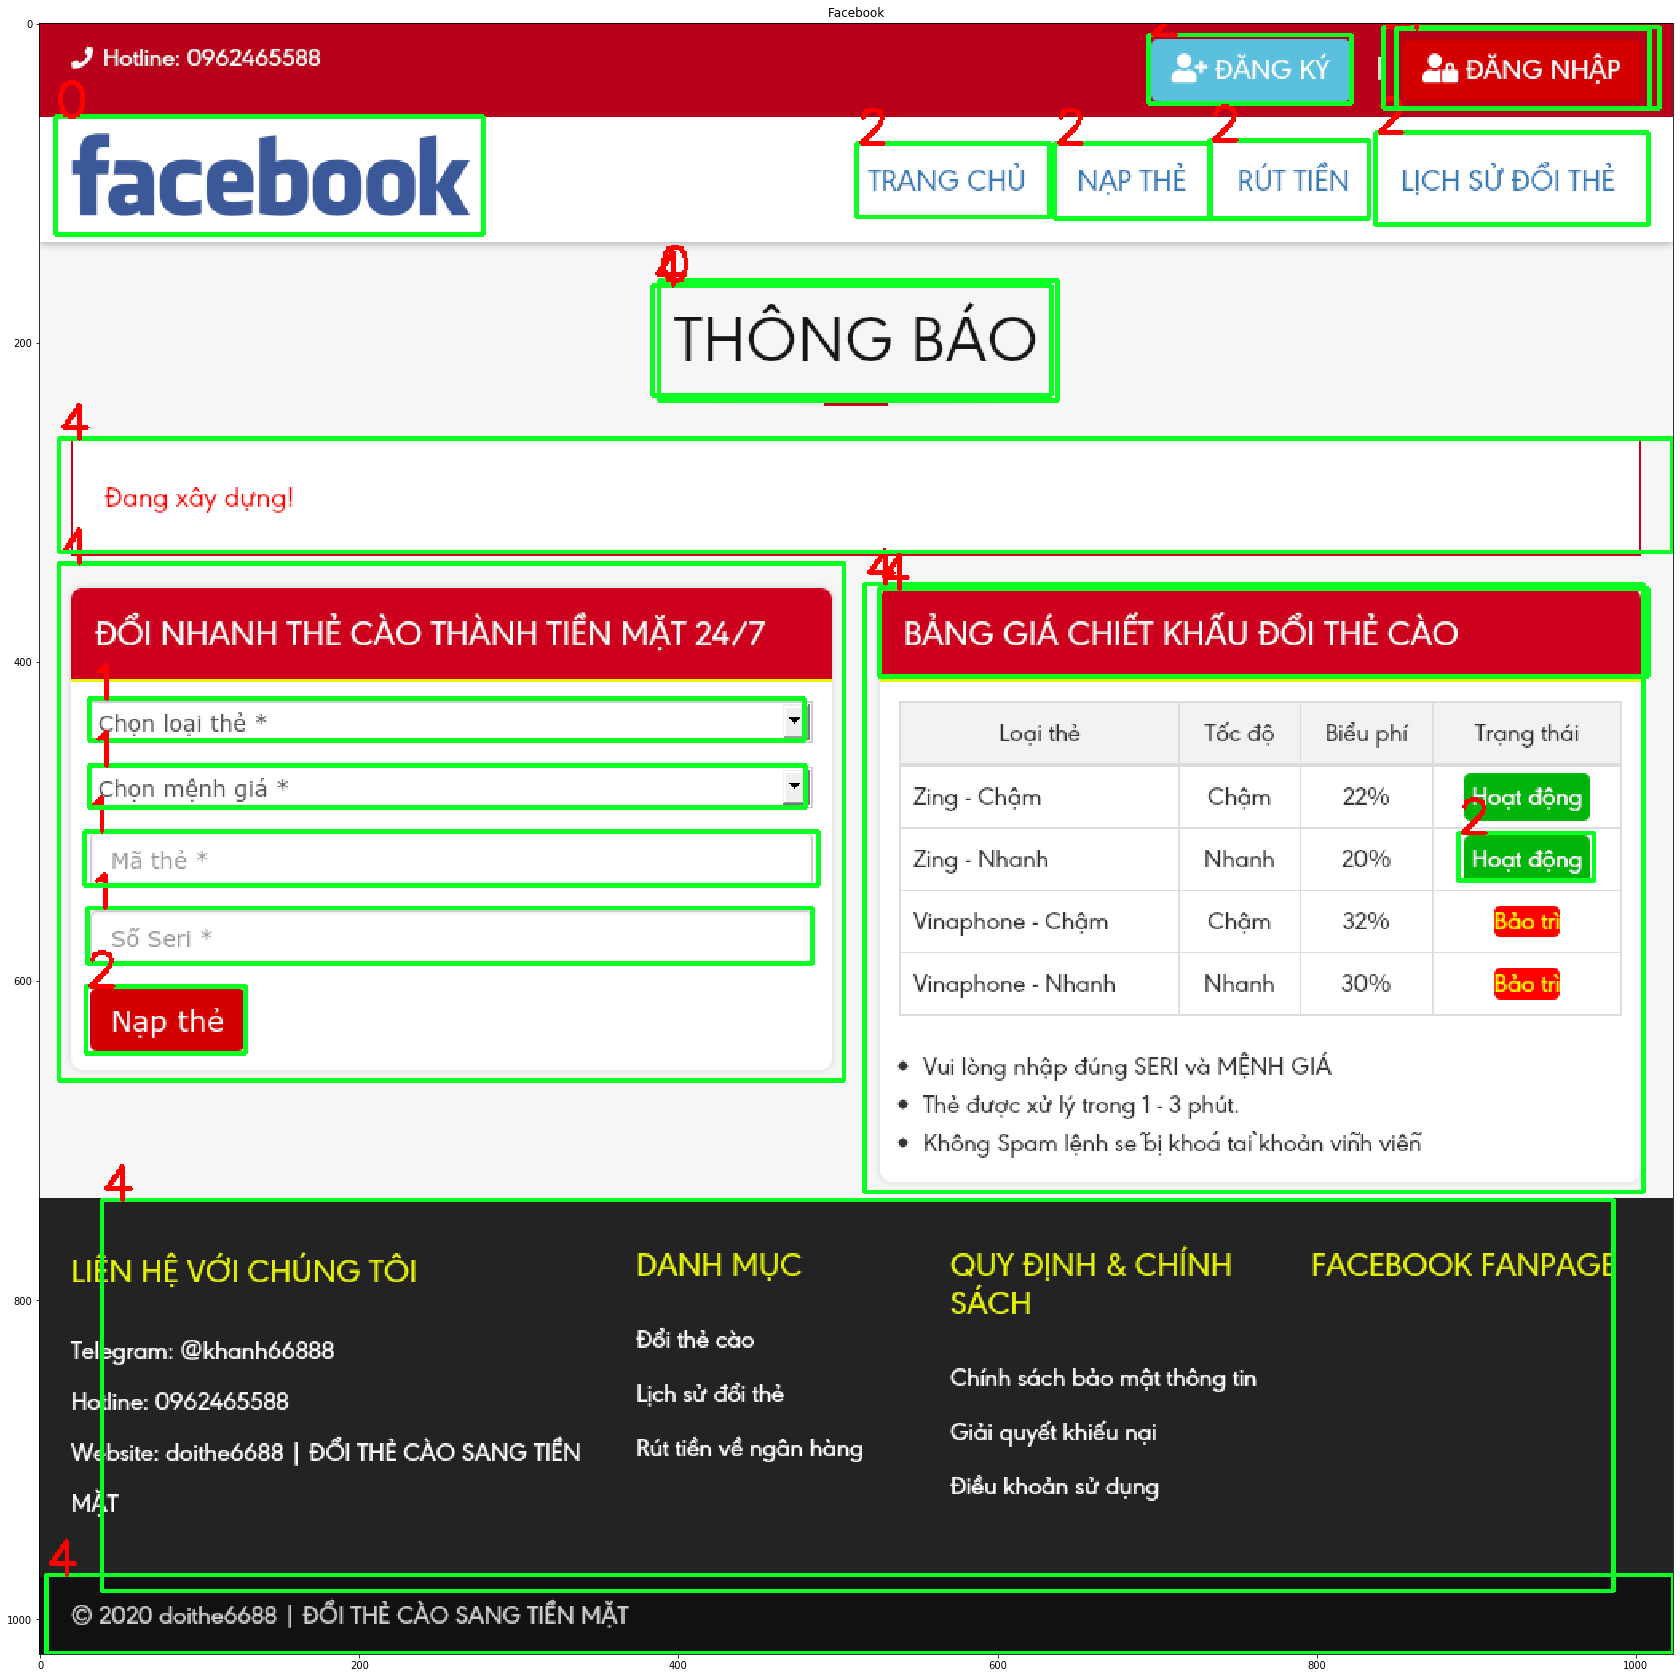

Credential category 0 with confidence None
www.davosginseng.ch


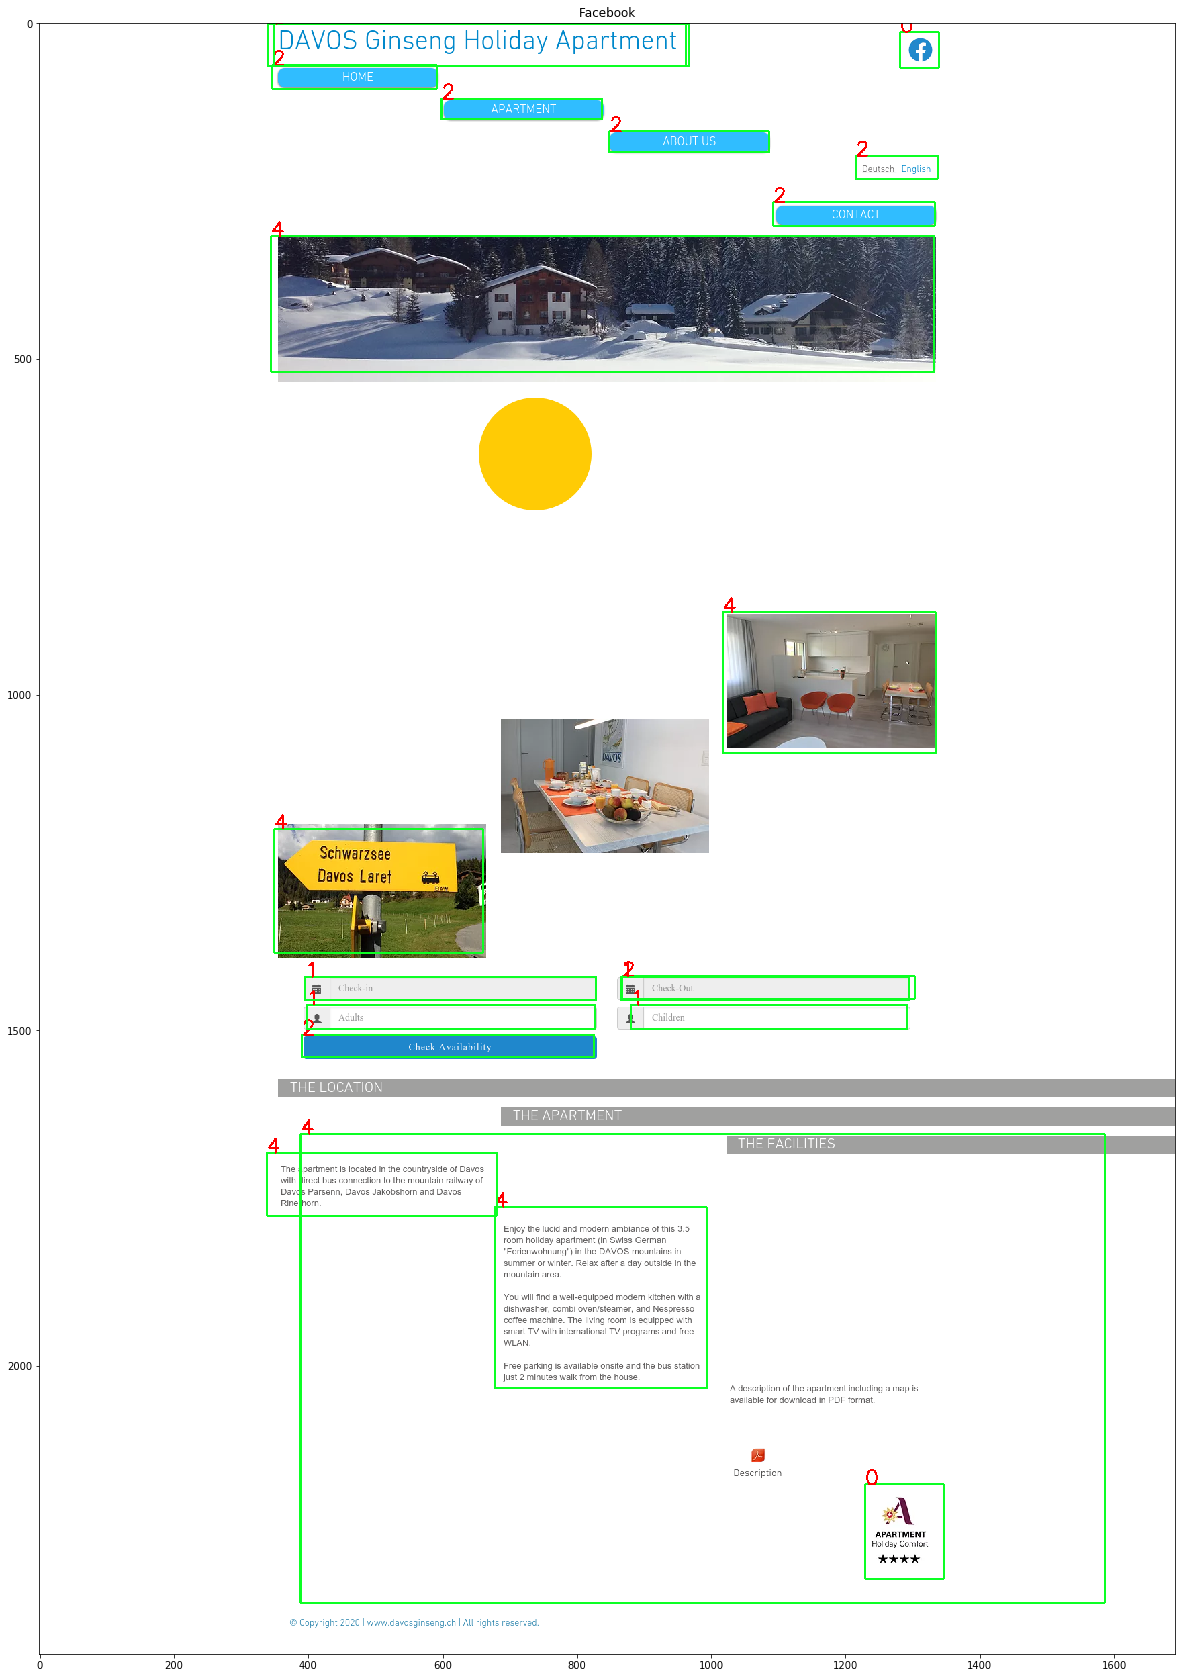

Credential category 0 with confidence None
fo-danonepff.info


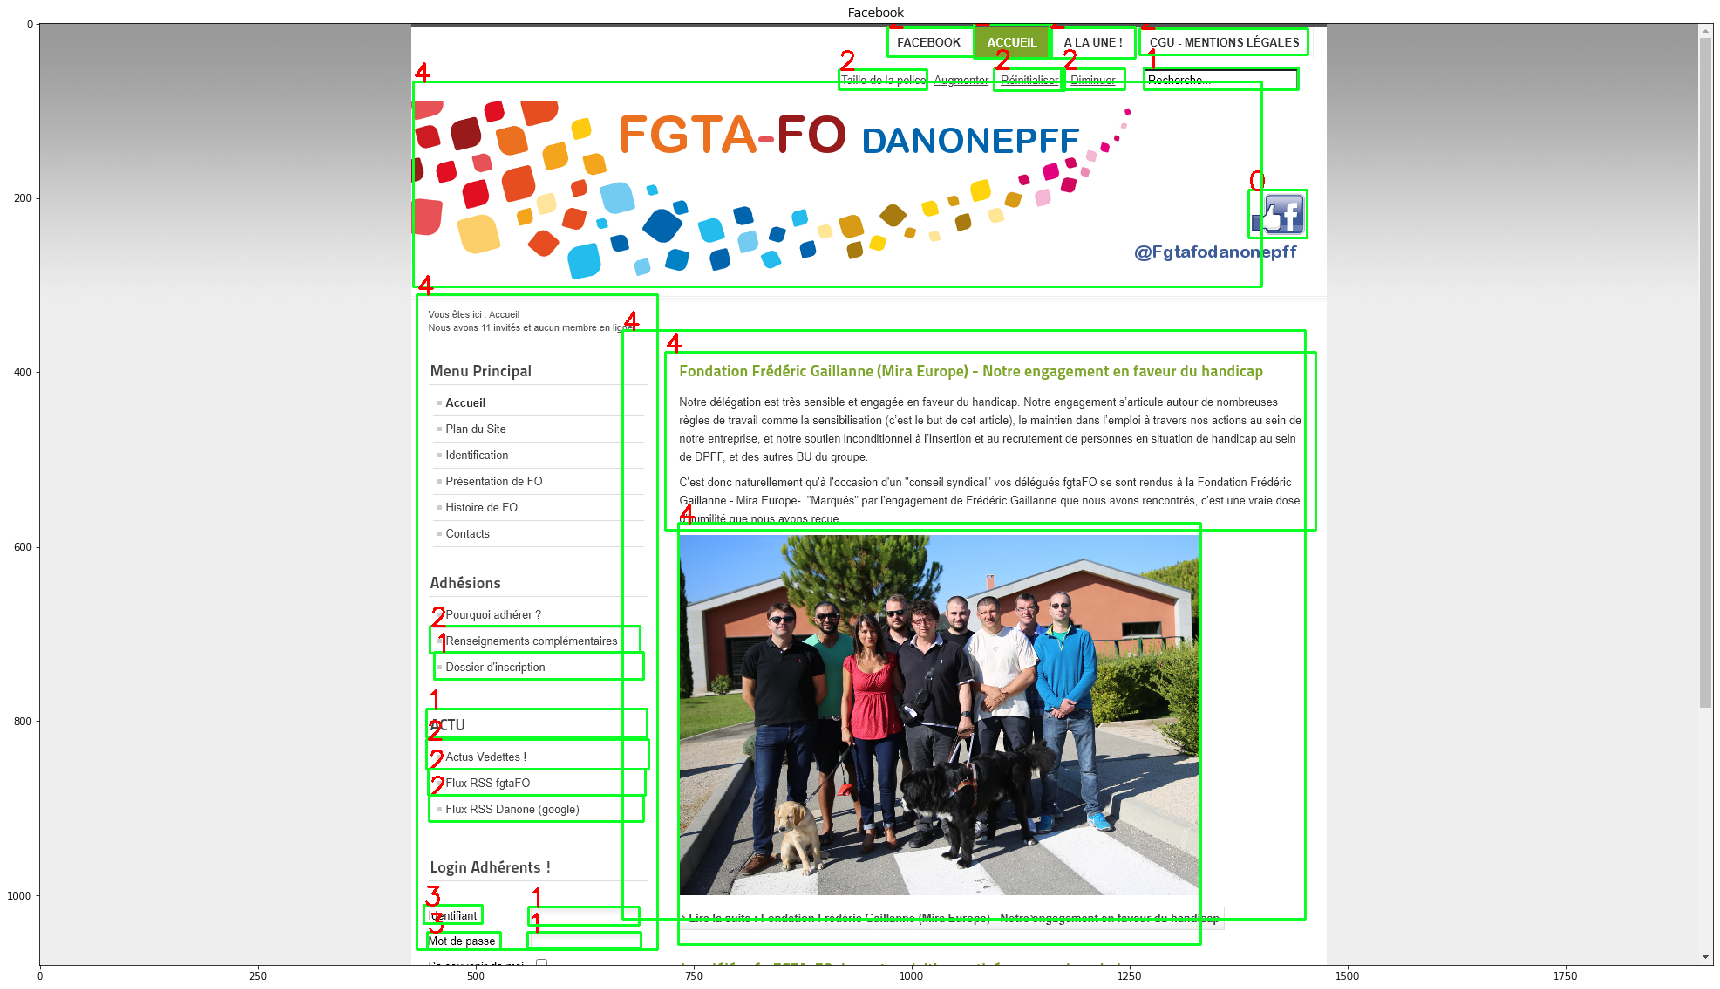

Credential category 0 with confidence None
pedalpeople.cc


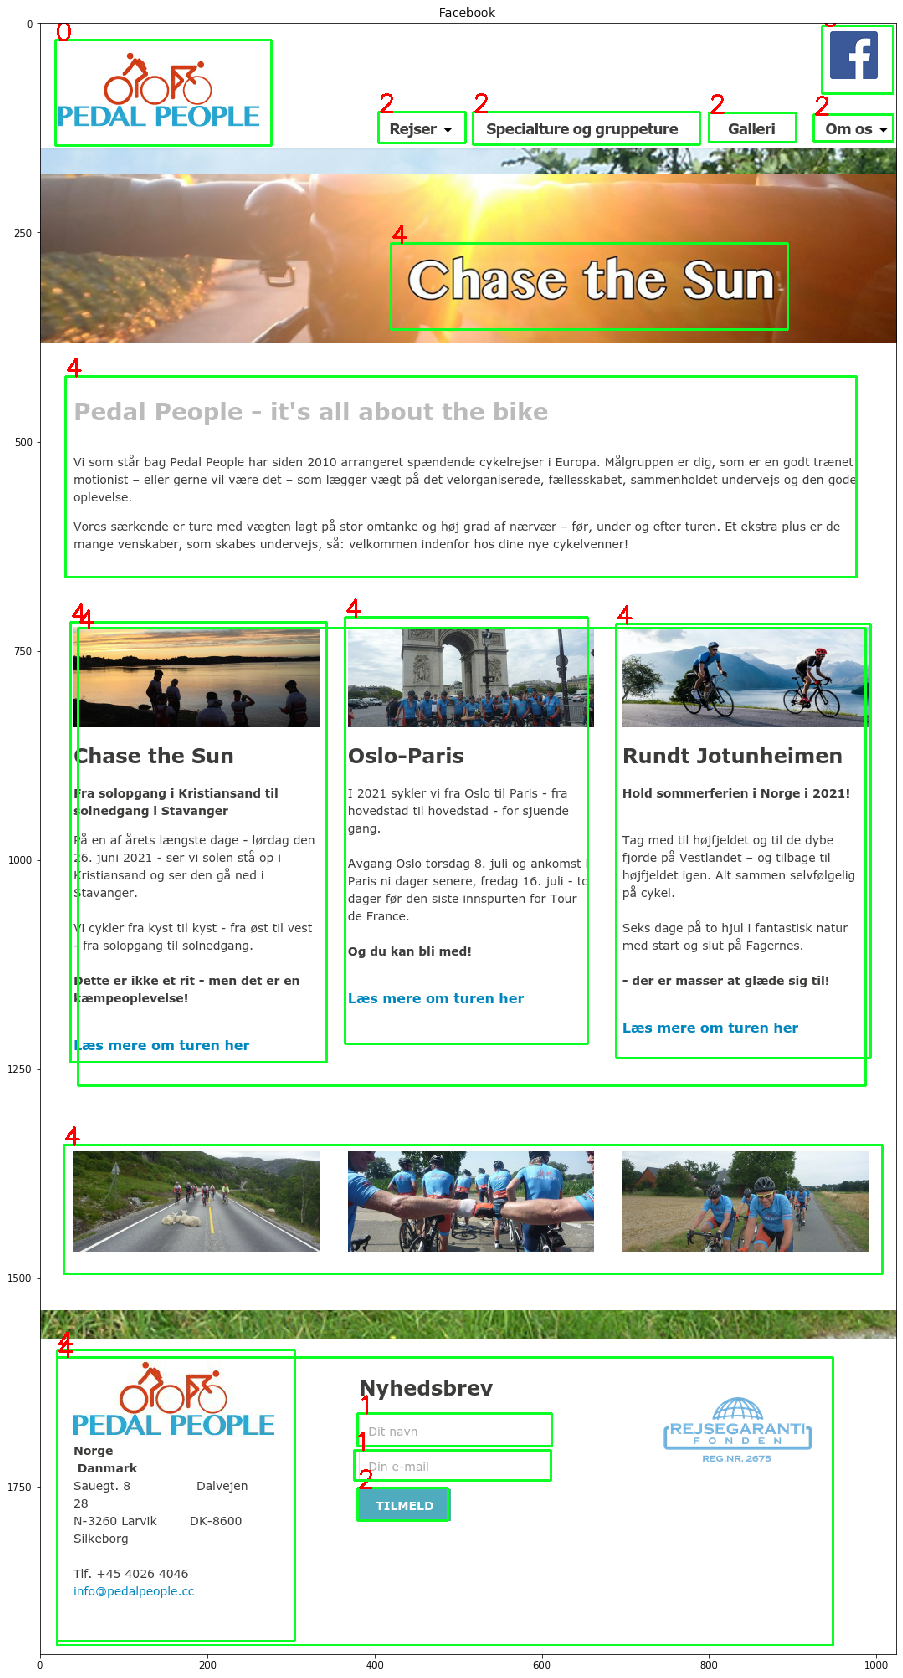

Credential category 0 with confidence None
maasa.co.za


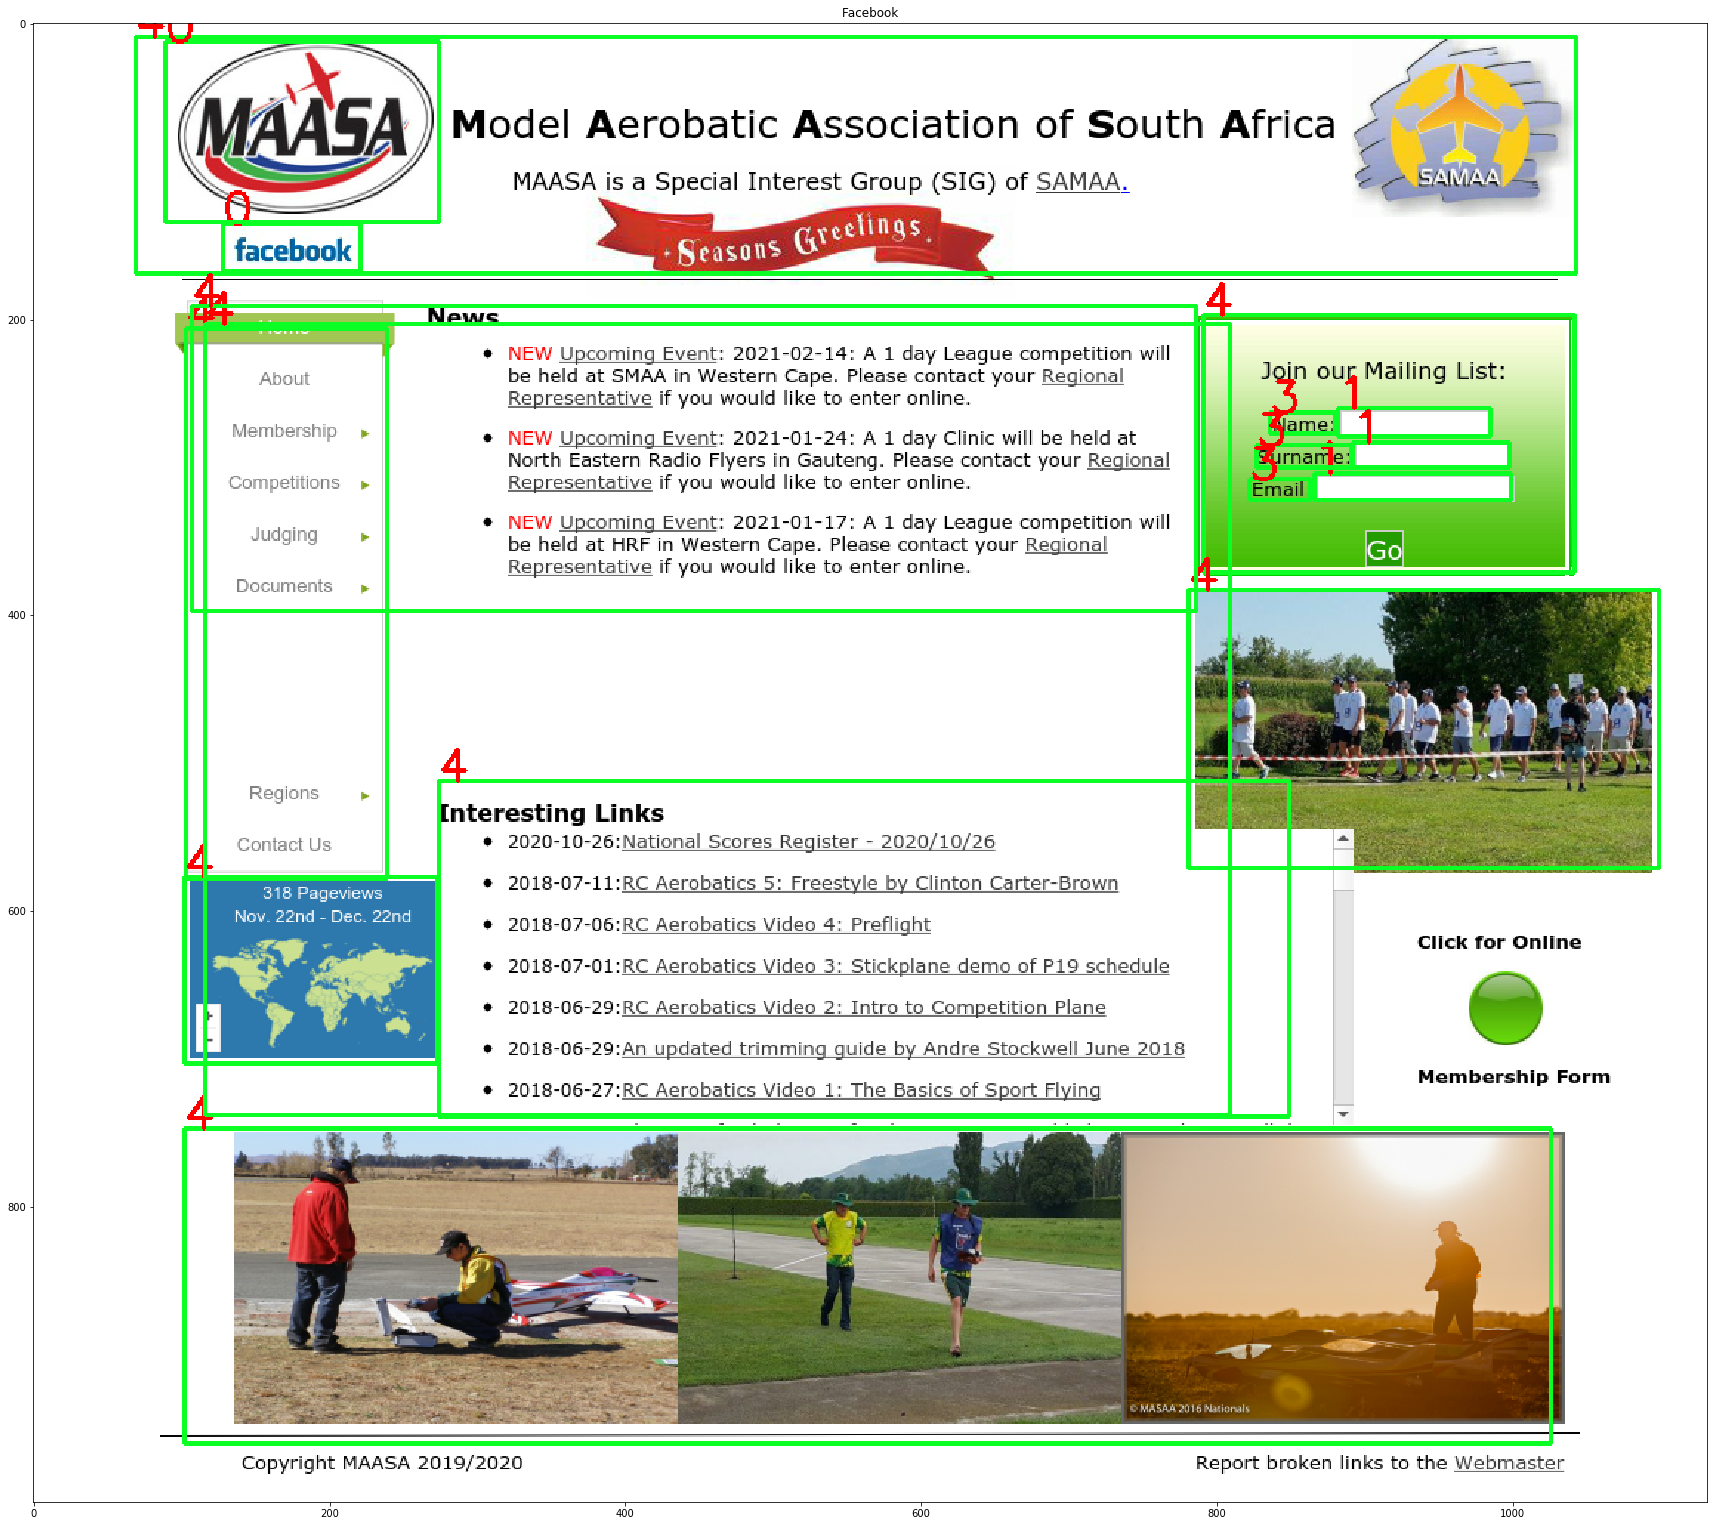

In [29]:
ct = 0
for folder in list(df_interest['folder']):

    img_path = '../phishpedia/benchmark/phish_discovery/All/fp/{}/shot.png'.format(folder)
    url = open('../phishpedia/benchmark/phish_discovery/All/fp/{}/info.txt'.format(folder), encoding = "ISO-8859-1").read()
    
    if list(df_interest.loc[df_interest['folder'] == folder]['pred_brand'])[0] != 'Facebook':
        continue

        
    # element recognition
    pred_classes, pred_boxes, pred_scores = element_recognition(img=img_path,
                                                                model=ele_model)
    # Credential heuristic module
    start_time = time.time()
    pattern_ct, len_input = layout_heuristic(pred_boxes, pred_classes)
    if len_input == 0:
        cre_pred = 1
        cre_conf = None
    elif pattern_ct >= 2:
        cre_pred = 0
        cre_conf = None
    else:
        # Credential classifier module
        cre_pred, cre_conf = credential_classifier(img=img_path, coords=pred_boxes, 
                                            types=pred_classes, model=cls_model)
        
    print("Credential category {} with confidence {}".format(cre_pred, cre_conf))
    
    # phishpedia
    if cre_pred == 0:
        pred_target = phishpedia_classifier(pred_classes=pred_classes, pred_boxes=pred_boxes, 
                                            domain_map_path=domain_map_path,
                                            model=pedia_model, 
                                            logo_feat_list=logo_feat_list, file_name_list=file_name_list,
                                            url=url,
                                            shot_path=img_path,
                                            ts=0.83)
        
    # plot show this image
    print(folder)
    check = cv2.imread(img_path)
    for j, box in enumerate(pred_boxes):
        cv2.rectangle(check, (box[0], box[1]), (box[2], box[3]), (36, 255, 12), 2)
        cv2.putText(check, str(pred_classes[j].item()), (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    plt.figure(figsize=(30,30))
    plt.imshow(check[:, :, ::-1])
    plt.title(pred_target)
    plt.show()
    
    ct += 1
    if ct >= 50:
        break

- Expand domain map

In [16]:
# with open(domain_map_path, 'rb') as handle:
#     domain_map = pickle.load(handle)

In [24]:
# new_map = {}
# for k,v in domain_map.items():
#     if brand_converter(k) not in domain_map.keys():
#         new_map[brand_converter(k)] = v
#     else:
#         pass

In [26]:
# domain_map.update(new_map)

In [ ]:
# for target in os.listdir('phishpedia/expand_targetlist/'):
#     if brand_converter(target) not in domain_map.keys():
#         print(brand_converter(target))

In [25]:
# domain_map['Lloyds TSB Group'] = ['lloydsbankinggroup', 'lloydsbank']

# class DomainDict():
    
#     def __init__(self, domain_map):
#         self.domain_map = domain_map
        
#     def _assign_value(self, key, value):
#         self.domain_map[key] = [value]
    
#     def main(self):
#         key_list = ['barclays', 'VKontakte', 'lcl', 'dkb', 'la_banque_postale', 'La Poste', 'EMS',
#                     'bcp', 'barclaycard', 'smiles', 'gov_uk', 'cryptobridge', 'ieee', 'strato',
#                     'adidas', 'fsnb', 'hfe', 'cetelem', 'Commonwealth Bank of Australia', 'zoominfo',
#                     'file_transfer', 'bradesco', 'postbank', 'Airbnb, Inc.', 'SMBC', 'snapchat', 
#                     'docmagic', 'Halifax Bank of Scotland Plc', 'GMX Mail', 'sicil_shop', 'cathay_bank',
#                     'otrs', 'mdpd', 'shoptet', 'tech_target', 'Yandex', 'summit_bank', 'Capitec Bank Limited',
#                     'Rakuten', 'ziggo', 'Magalu', 'wp60', 'Rabobank Nederland', 'latam', 'capital_one',
#                     'db', 'qnb', 'momentum_office_design', 'Fifth Third Bank', 'banco_de_occidente', 'htb',
#                     'orange_rockland', 'Twitter, Inc.', 'Azul', 'ameli_fr', 'typeform', 'cogeco',
#                     'banco_inter', 'itunes', 'netsons', 'Three UK', 'bahia', 'test_rite', 'anadolubank',
#                     'mbank', 'walmart', 'cloudns', 'crate_and_barrel', 'Boxberry', 'xtrix_tv', 'etrade', 
#                     'taxact', 'BNP Paribas', 'ocn', 'Raiffeisen Bank S.A.', 'fnac', 'arnet_tech',
#                     'nordea', 'sunrise', 'infinisource', 'paschoalotto', 'grupo_bancolombia', 'youtube',
#                     'Banco de Cordoba', 'erste', 'cloudconvert', 'ms_bing', 'EE Limited', 'timeweb',
#                     'knab', 'sharp', 'smartsheet', 'bestchange', 'blizzard', 'ms_skype', 'eharmony']
        
#         value_list = ['barclays', 'vk', 'lcl', 'dkb', 'labanquepostale', 'laposte', 'ems',
#                     'viabcp', 'barclaycard', 'smiles', 'gov', 'cryptobridge', 'ieee', 'strato',
#                     'adidas', 'fsnb', 'hfe', 'cetelem', 'Commonwealth Bank of Australia', 'zoominfo',
#                     'filetransfer', 'banco', 'postbank', 'airbnb', 'smbc', 'snapchat', 
#                     'docmagic', 'halifax', 'gmx', 'sicilshop', 'cathaybank',
#                     'otrs', 'mps', 'shoptet', 'tech_target', 'yandex', 'summitbank', 'capitecbank',
#                     'rakuten', 'ziggo', 'magazineluiza', 'wp60', 'rabobank', 'latam', 'capitalone',
#                     'db', 'qnb', 'momentumoffice', '53', 'bancodeoccidente', 'htb',
#                     'oru', 'twitter', 'azul', 'ameli', 'typeform', 'cogeco',
#                     'bancointer', 'apple', 'netsons', 'three', 'casasbahia', 'testritegroup', 'anadolubank',
#                     'mbank', 'walmart', 'cloudns', 'crateandbarrel', 'boxberry', 'xtrixtv', 'etrade', 
#                     'taxact', 'bnpparibas', 'tving', 'raiffeisen', 'fnac', 'arnettechnologies',
#                     'nordea', 'sunrise', 'infinisource', 'paschoalotto', 'grupobancolombia', 'youtube',
#                     'bancor', 'erstegroup', 'cloudconvert', 'bing', 'ee', 'timeweb',
#                     'knab', 'sharp', 'smartsheet', 'bestchange', 'blizzard', 'skype', 'eharmony']
        
#         assert len(key_list) == len(value_list)
        
#         for i, key in enumerate(key_list):
#             self._assign_value(key, value_list[i])
            
#         return self.domain_map

In [26]:
# domaindict = DomainDict(domain_map)

In [27]:
# domain_map_after = domaindict.main()

In [29]:
# with open(domain_map_path, 'wb') as handle:
#     pickle.dump(domain_map, handle)